## Final SHAP, LRP & attention scores with Attention-LSTM -- CDiff Dataset
**Authors:** 
* Lin Lee Cheong<br>
* Tesfagabir Meharizghi<br>

**Last Updated: 03/18/2021**

Dataset:
- CMSAI CDiff Dataset

Data Processing:
- In this final experiment, we used downsampled version of the training dataset to balance the number positives and negatives.
- The training split uses all the positives from all months of data (but the negatives are downsampled)
- Removed all the patients that are found in val/test splits to avoid data leakage
- Val/Test datasets are only from one month of data (`20110101`) - highly imbalanced

Model:
* LSTM + Attention

**Steps:** <br>
1. Read in dataset
2. LSTM model training
3. Extract SHAP, attention and relevance scores for a TEST set
3. Extract SHAP and relevance scores for example set of 4
4. Save output in dict format

In [1]:
%load_ext lab_black

%load_ext autoreload

%autoreload 2

In [2]:
import sys

sys.path.append("../")
sys.path.append("../../")

import os
import json
import time
import torch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from urllib.parse import urlparse
import tarfile
import pickle
import shutil
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
import numpy as np
from numpy import newaxis as na

import deep_id_pytorch

from lstm_models import *
from att_lstm_models import *
from lstm_utils import *
from xgboost_utils import *

# from lrp_att_model import *
import shap_jacc_utils as sj_utils

# import rbo

In [10]:
MODEL_NAME = "lstm-att-lrp"

NROWS = 1e9

TRAIN_MODEL = False
SEQ_LEN = 100
MODEL_PARAMS = {
    "min_freq": 1000,
}

N_EPOCHS = 10

TARGET_COLNAME = "d_00845"
UID_COLNAME = "patient_id"
TARGET_VALUE = "1"

DATA_TYPE = "original"  # "downsampled"
FNAME = "20110101"  # "all"


# #suffix = '5_times_positives'
# #TRAIN_DATA_PATH = f"../../../data/AE_CDiff_d00845/output/data/1000/downsampled/preprocessed_v2/splits/all/train.csv"
# TRAIN_DATA_PATH = f"../../../data/AE_CDiff_d00845/output/data/1000/{DATA_TYPE}/preprocessed_v2/splits/{FNAME}/train_balanced.csv"
# VALID_DATA_PATH = f"../../../data/AE_CDiff_d00845/output/data/1000/{DATA_TYPE}/preprocessed_v2/splits/{FNAME}/val.csv"
# TEST_DATA_PATH = f"../../../data/AE_CDiff_d00845/output/data/1000/{DATA_TYPE}/preprocessed_v2/splits/{FNAME}/test.csv"
# SELECTED_EXAMPLES_PATH = f"../../../data/AE_CDiff_d00845/output/data/1000/{DATA_TYPE}/preprocessed_v2/splits/{FNAME}/visualized_test_patients.txt"

# These are the version of dataset where all the positive examples of val/test are at the beginning
TRAIN_DATA_PATH = f"./output-mix/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/splits/{FNAME}/{MODEL_PARAMS['min_freq']}/train_balanced.csv"
VALID_DATA_PATH = f"./output-mix/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/splits/{FNAME}/{MODEL_PARAMS['min_freq']}/val_positives_first.csv"
TEST_DATA_PATH = f"./output-mix/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/splits/{FNAME}/{MODEL_PARAMS['min_freq']}/test_positives_first.csv"
SELECTED_EXAMPLES_PATH = f"./output-mix/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/splits/{FNAME}/{MODEL_PARAMS['min_freq']}/visualized_test_patients.txt"

VOCAB_PATH = f"./output-mix/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/splits/{FNAME}/{MODEL_PARAMS['min_freq']}/vocab.pkl"

GT_CODES_PATH = "../../../data/AE_CDiff_d00845/cdiff_risk_factors_codes.csv"

MODEL_SAVE_PATH_PATTERN = f"./output-mix/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/{FNAME}/{MODEL_PARAMS['min_freq']}/model_weights/model_{'{}'}.pkl"
SHAP_SAVE_DIR_PATTERN = f"./output-mix/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/{FNAME}/{MODEL_PARAMS['min_freq']}/shap/{'{}'}_shap_{'{}'}.pkl"  # SHAP values path for a given dataset split

OUTPUT_RESULTS_PATH = f"output-mix/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/{FNAME}/{MODEL_PARAMS['min_freq']}/train_results/results.csv"
PARAMS_PATH = f"output-mix/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/{FNAME}/{MODEL_PARAMS['min_freq']}/train_results/model_params.json"

PLOT_SAVE_DIR = f"./output-mix/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/{MODEL_NAME}/{FNAME}/{MODEL_PARAMS['min_freq']}/plots/"

XGB_BEST_SHAP_PATH = f"./output-mix/AE_CDiff/{SEQ_LEN}/{DATA_TYPE}/xgb/{FNAME}/{MODEL_PARAMS['min_freq']}/shap/test_shap_17.pkl"


# Model Parameters
MODEL_PARAMS = {
    # Dataset/vocab related
    "min_freq": 1,
    "batch_size": 128,
    "num_eval_val": 200,
    "num_eval_test": 200,
    # Model related parameters
    "embedding_dim": 8,
    "hidden_dim": 16,
    "nlayers": 2,
    "bidirectional": True,
    "dropout": 0.3,
    "linear_bias": False,
    "init_type": "zero",  # zero/learned
    "learning_rate": 0.01,  # 0.01,
    "scheduler_step": 3,
    "clip": False,
    "rev": False,
    # SHAP-related parameters
    "n_background": 300,  # Number of background examples
    "background_negative_only": True,  # If negative examples are used as background
    "background_positive_only": False,
    "test_positive_only": False,
    "is_test_random": False,
    "n_valid_examples": 128,  # Number of validation examples to be used during shap computation
    "n_test_examples": 128,  # Number of the final test examples to be used in shap computation #TODO
}

In [11]:
def get_wtau(x, y):
    return stats.weightedtau(x, y, rank=None)[0]


def get_rbo(x, y, uid, p=0.7):
    x_idx = np.argsort(x)[::-1]
    y_idx = np.argsort(y)[::-1]

    return rbo.RankingSimilarity(
        [uid[idx] for idx in x_idx], [uid[idx] for idx in y_idx]
    ).rbo(p=p)


# calculate ground truth scores
def is_value(x, data="synthetic"):
    if data == "synthetic":
        if "_N" in x:
            return False
        return True
    else:
        if x.endswith("_rf"):
            return True
        return False


class AttNoHtLSTM(SimpleLSTM):
    def __init__(
        self,
        emb_dim,
        hidden_dim,
        vocab,
        device,
        nlayers=1,
        bidi=True,
        use_gpu=True,
        pad_idx=0,
        dropout=None,
        init_type="zero",
        linear_bias=True,
    ):
        super(AttNoHtLSTM, self).__init__(
            emb_dim=emb_dim, hidden_dim=hidden_dim, vocab=vocab, device=device
        )

        self.device = device
        self.use_gpu = use_gpu

        self.emb_dim = emb_dim
        self.input_dim = len(vocab)
        self.vocab = vocab
        self.pad_idx = pad_idx
        self.emb_layer = nn.Embedding(self.input_dim, emb_dim, padding_idx=pad_idx)

        self.hidden_dim = hidden_dim
        self.bidi = bidi
        self.nlayers = nlayers
        self.linear_bias = linear_bias

        """
        self.attn_layer = (
            nn.Linear(hidden_dim *2, 1, bias=linear_bias) 
            if bidi else nn.Linear(hidden_dim, 1, bias=linear_bias)
        )
        """
        if dropout is None:
            self.lstm = nn.LSTM(
                input_size=emb_dim,
                hidden_size=hidden_dim,
                num_layers=nlayers,
                bidirectional=bidi,
                batch_first=True,
            )
        else:
            self.lstm = nn.LSTM(
                input_size=emb_dim,
                hidden_size=hidden_dim,
                num_layers=nlayers,
                bidirectional=bidi,
                batch_first=True,
                dropout=dropout,
            )

        self.pred_layer = (
            nn.Linear(hidden_dim * 2, 1, bias=linear_bias)
            if bidi
            else nn.Linear(hidden_dim, 1, bias=linear_bias)
        )

        self.dpt = nn.Dropout(dropout)

        """
        self.context_layer = (
            nn.Linear(hidden_dim * 2, 1, bias=linear_bias) 
            if bidi else nn.Linear(hidden_dim, 1, bias=linear_bias)
        )
        """
        self.init_weights()

    def forward(self, tokens, ret_attn=False):

        if self.dpt is not None:
            embedded = self.dpt(self.emb_layer(tokens))
        else:
            embedded = self.emb_layer(tokens)

        if self.init_type == "learned":
            self.h0.requires_grad = True
            self.c0.requires_grad = True
            hidden = (
                self.h0.repeat(1, tokens.shape[0], 1),
                self.c0.repeat(1, tokens.shape[0], 1),
            )

        else:  # default behavior
            hidden = self.init_hidden(tokens.shape[0])
            hidden = self.repackage_hidden(hidden)

        text_lengths = torch.sum(tokens != self.pad_idx, dim=1).to("cpu")

        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths, enforce_sorted=False, batch_first=True
        )

        packed_output, (final_hidden, cell) = self.lstm(packed_embedded, hidden)

        output, output_lengths = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True, total_length=tokens.shape[1]
        )

        if self.bidi:
            out = torch.cat(
                [output[:, -1, : self.hidden_dim], output[:, 0, self.hidden_dim :]],
                dim=1,
            )
        else:
            out = output[:, -1, :]

        # Switch to multiplicative attention
        mask_feats = np.array(tokens.cpu().numpy() == 0)
        mask_feats = -1000 * mask_feats.astype(np.int)

        mask_feats = torch.Tensor(mask_feats).to(self.device)

        attn_weights_int = torch.bmm(output, out.unsqueeze(2)).squeeze(2) / (
            (tokens.shape[1]) ** 0.5
        )
        attn_weights = nn.functional.softmax(attn_weights_int + mask_feats, -1)

        context = torch.bmm(output.transpose(1, 2), attn_weights.unsqueeze(-1)).squeeze(
            -1
        )

        concat_out = context

        if self.dpt is not None:
            pred = self.pred_layer(self.dpt(concat_out))
        else:
            pred = self.pred_layer(concat_out)

        if ret_attn:
            return (
                pred.detach().cpu().numpy(),
                attn_weights.detach().cpu().numpy(),
                context.detach().cpu().numpy(),
                attn_weights_int.detach().cpu().numpy(),
                out.detach().cpu().numpy(),
                output.detach().cpu().numpy(),
            )

        return pred

    def forward_shap(self, token_ids, mask, full_id_matrix=False):
        token_ids = token_ids if token_ids.is_cuda else token_ids.to(self.device)

        if self.init_type == "learned":
            self.h0.requires_grad = False
            self.c0.requires_grad = False

            hidden = (self.h0.repeat(1, 1, 1), self.c0.repeat(1, 1, 1))

        else:  # default behavior
            hidden = self.init_hidden(1)
            hidden = self.repackage_hidden(hidden)

        token_ids[sum(mask) :, :] = 0
        embedded = torch.matmul(token_ids, self.emb_layer.weight).unsqueeze(0)

        embedded = embedded[:, : sum(mask), :]

        output, _ = self.lstm(embedded, hidden)

        # output = output.permute(1, 0, 2)  # [batch, text_length, hidden_dim]
        # print(f'Output dimensions: {output.shape}')
        if self.bidi:
            out = torch.cat(
                [output[:, -1, : self.hidden_dim], output[:, 0, self.hidden_dim :]],
                dim=1,
            )
        else:
            out = output[:, -1, :]
        # import IPython.core.debugger

        # dbg = IPython.core.debugger.Pdb()
        # dbg.set_trace()

        # print(f'Stacked hidden dimensions: {stacked_hidden.shape}')
        # print(f'mask weight dimensions: {mask_feats.shape}')
        # attention = self.context_layer(output).squeeze(-1)
        # att_weights = nn.functional.softmax(attention, dim=-1)
        # context = torch.bmm(att_weights.unsqueeze(1), output).squeeze(1)
        attn_weights = torch.bmm(output, out.unsqueeze(2)).squeeze(2) / (
            sum(mask) ** 0.5
        )

        soft_attn_weights = nn.functional.softmax(attn_weights, 1)

        context = torch.bmm(
            output.transpose(1, 2), soft_attn_weights.unsqueeze(-1)
        ).squeeze(-1)

        # concat_out = torch.cat((context, out), dim=1)
        concat_out = context
        pred = self.pred_layer(concat_out)

        return pred


class LSTM_LRP_MultiLayer:
    def __init__(self, pymodel):
        super(LSTM_LRP_MultiLayer, self).__init__()

        self.init_model(pymodel)

    def init_model(self, pymodel):

        self.device = pymodel.device
        self.use_gpu = pymodel.use_gpu
        self.bidi = pymodel.bidi

        self.emb_dim = pymodel.emb_dim
        self.vocab = pymodel.vocab
        self.input_dim = len(self.vocab)
        self.pad_idx = pymodel.pad_idx
        self.hidden_dim = pymodel.hidden_dim

        self.emb = pymodel.emb_layer.weight.detach().numpy()

        param_list = list(pymodel.lstm.named_parameters())
        param_dict = {}
        for param_tuple in param_list:
            param_dict[param_tuple[0]] = param_tuple[-1].detach().numpy()

        # rearrange, pytorch uses ifgo format, need to move to icfo/igfo format
        idx_list = (
            list(range(0, self.hidden_dim))
            + list(range(self.hidden_dim * 2, self.hidden_dim * 3))
            + list(range(self.hidden_dim, self.hidden_dim * 2))
            + list(range(self.hidden_dim * 3, self.hidden_dim * 4))
        )
        self.nlayers = pymodel.nlayers

        # i (input), g (candidate), f (forget), o (output) order
        # (4 * hidden_dim, emb_dim)
        self.Wxh_Left = {}
        self.bxh_Left = {}
        self.Whh_Left = {}
        self.bhh_Left = {}

        if self.bidi:
            self.Wxh_Right = {}
            self.bxh_Right = {}
            self.Whh_Right = {}
            self.bhh_Right = {}

        for layer in range(self.nlayers):
            self.Wxh_Left[layer] = param_dict[f"weight_ih_l{layer}"][idx_list]
            self.bxh_Left[layer] = param_dict[f"bias_ih_l{layer}"][idx_list]  # shape 4d
            self.Whh_Left[layer] = param_dict[f"weight_hh_l{layer}"][
                idx_list
            ]  # shape 4d*d
            self.bhh_Left[layer] = param_dict[f"bias_hh_l{layer}"][idx_list]  # shape 4d

            if self.bidi:
                # LSTM right encoder
                self.Wxh_Right[layer] = param_dict[f"weight_ih_l{layer}_reverse"][
                    idx_list
                ]
                self.bxh_Right[layer] = param_dict[f"bias_ih_l{layer}_reverse"][
                    idx_list
                ]
                self.Whh_Right[layer] = param_dict[f"weight_hh_l{layer}_reverse"][
                    idx_list
                ]
                self.bhh_Right[layer] = param_dict[f"bias_hh_l{layer}_reverse"][
                    idx_list
                ]

        # START ADDED: CONTEXT LAYER INIT
        # linear output layer: shape C * 4d
        # 0-d: fwd & context
        # d-2d: rev & context
        # 2d-3d: fwd & final hidden
        # 3d-4d: rev & final hidden
        Why = pymodel.pred_layer.weight.detach().numpy()

        self.Why_Left = Why[:, 2 * self.hidden_dim : 3 * self.hidden_dim]  # shape C*d

        if self.bidi:
            self.Why_Right = Why[:, 3 * self.hidden_dim :]  # shape C*d

        self.Wcy_Left = Why[:, : self.hidden_dim]

        if self.bidi:
            self.Wcy_Right = Why[:, self.hidden_dim : 2 * self.hidden_dim]
        # END ADDED: CONTEXT LAYER INIT

    def set_input(self, tokens):
        T = len(tokens)  # sequence length
        d = int(self.Wxh_Left[0].shape[0] / 4)  # hidden layer dimension
        e = self.emb.shape[1]  # word embedding dimension

        self.w = tokens
        self.x = {}
        self.x_rev = {}
        x = np.zeros((T, e))
        x[:, :] = self.emb[tokens, :]
        self.x[0] = x
        self.x_rev[0] = x[::-1, :].copy()
        self.h_Left = {}
        self.c_Left = {}

        if self.bidi:
            self.h_Right = {}
            self.c_Right = {}

        for layer in range(self.nlayers):
            self.h_Left[layer] = np.zeros((T + 1, d))
            self.c_Left[layer] = np.zeros((T + 1, d))

            if self.bidi:
                self.h_Right[layer] = np.zeros((T + 1, d))
                self.c_Right[layer] = np.zeros((T + 1, d))

        self.att_score = None

    def forward_gate(self, layer, t, idx, idx_i, idx_g, idx_f, idx_o, gate_dir):

        if gate_dir == "left":
            self.gates_xh_Left[layer][t] = np.dot(
                self.Wxh_Left[layer], self.x[layer][t]
            )
            self.gates_hh_Left[layer][t] = np.dot(
                self.Whh_Left[layer], self.h_Left[layer][t - 1]
            )
            self.gates_pre_Left[layer][t] = (
                self.gates_xh_Left[layer][t]
                + self.gates_hh_Left[layer][t]
                + self.bxh_Left[layer]
                + self.bhh_Left[layer]
            )
            self.gates_Left[layer][t, idx] = 1.0 / (
                1.0 + np.exp(-self.gates_pre_Left[layer][t, idx])
            )
            self.gates_Left[layer][t, idx_g] = np.tanh(
                self.gates_pre_Left[layer][t, idx_g]
            )
            self.c_Left[layer][t] = (
                self.gates_Left[layer][t, idx_f] * self.c_Left[layer][t - 1]
                + self.gates_Left[layer][t, idx_i] * self.gates_Left[layer][t, idx_g]
            )
            self.h_Left[layer][t] = self.gates_Left[layer][t, idx_o] * np.tanh(
                self.c_Left[layer][t]
            )

        if gate_dir == "right":
            self.gates_xh_Right[layer][t] = np.dot(
                self.Wxh_Right[layer], self.x_rev[layer][t]
            )
            self.gates_hh_Right[layer][t] = np.dot(
                self.Whh_Right[layer], self.h_Right[layer][t - 1]
            )
            self.gates_pre_Right[layer][t] = (
                self.gates_xh_Right[layer][t]
                + self.gates_hh_Right[layer][t]
                + self.bxh_Right[layer]
                + self.bhh_Right[layer]
            )
            self.gates_Right[layer][t, idx] = 1.0 / (
                1.0 + np.exp(-self.gates_pre_Right[layer][t, idx])
            )
            self.gates_Right[layer][t, idx_g] = np.tanh(
                self.gates_pre_Right[layer][t, idx_g]
            )
            self.c_Right[layer][t] = (
                self.gates_Right[layer][t, idx_f] * self.c_Right[layer][t - 1]
                + self.gates_Right[layer][t, idx_i] * self.gates_Right[layer][t, idx_g]
            )
            self.h_Right[layer][t] = self.gates_Right[layer][t, idx_o] * np.tanh(
                self.c_Right[layer][t]
            )

    def forward_lrp(self):
        """
        Standard forward pass.
        Compute the hidden layer values (assuming input x/x_rev was previously set)
        """
        T = len(self.w)
        d = int(self.Wxh_Left[0].shape[0] / 4)

        # gate indices (assuming the gate ordering in the LSTM weights is i,g,f,o):
        idx = np.hstack((np.arange(0, d), np.arange(2 * d, 4 * d))).astype(
            int
        )  # indices of gates i,f,o together
        idx_i, idx_g, idx_f, idx_o = (
            np.arange(0, d),
            np.arange(d, 2 * d),
            np.arange(2 * d, 3 * d),
            np.arange(3 * d, 4 * d),
        )  # indices of gates i,g,f,o separately

        # initialize
        self.gates_xh_Left = {}
        self.gates_hh_Left = {}
        self.gates_pre_Left = {}
        self.gates_Left = {}

        if self.bidi:
            self.gates_xh_Right = {}
            self.gates_hh_Right = {}
            self.gates_pre_Right = {}
            self.gates_Right = {}

        for layer in range(self.nlayers):
            self.gates_xh_Left[layer] = np.zeros((T, 4 * d))
            self.gates_hh_Left[layer] = np.zeros((T, 4 * d))
            self.gates_pre_Left[layer] = np.zeros((T, 4 * d))  # gates pre-activation
            self.gates_Left[layer] = np.zeros((T, 4 * d))  # gates activation

            if self.bidi:
                self.gates_xh_Right[layer] = np.zeros((T, 4 * d))
                self.gates_hh_Right[layer] = np.zeros((T, 4 * d))
                self.gates_pre_Right[layer] = np.zeros((T, 4 * d))
                self.gates_Right[layer] = np.zeros((T, 4 * d))

        # START ADDED: INITIALIZE CONTEXT LAYERS
        self.ctxt_Left = np.zeros((1, d))
        self.ctxt_Right = np.zeros((1, d))
        self.att_wgt_Left = np.zeros((T, 1))
        self.att_wgt_Right = np.zeros((T, 1))
        self.att_score = np.zeros((T, 1))

        # END ADDED: INITIALIZE CONTEXT LAYERS

        # START EDIT: cycle through first layer first
        layer = 0
        for t in range(T):
            self.forward_gate(
                layer, t, idx, idx_i, idx_g, idx_f, idx_o, gate_dir="left"
            )
            if self.bidi:
                self.forward_gate(
                    layer, t, idx, idx_i, idx_g, idx_f, idx_o, gate_dir="right"
                )

        # go through all the rest of the layers
        if self.nlayers > 1:
            ## TODO: fix init t-1 (zero time step) Zeroes!!
            self.x[layer + 1] = (
                np.concatenate(
                    (self.h_Left[layer][:T], self.h_Right[layer][:T][::-1]), axis=1
                )
                if self.bidi
                else self.h_Left[layer][:T]
            )

            self.x_rev[layer + 1] = self.x[layer + 1][::-1].copy()

            for layer in range(1, self.nlayers):
                for t in range(T):
                    self.forward_gate(
                        layer, t, idx, idx_i, idx_g, idx_f, idx_o, gate_dir="left"
                    )
                    if self.bidi:
                        self.forward_gate(
                            layer, t, idx, idx_i, idx_g, idx_f, idx_o, gate_dir="right"
                        )

                    self.x[layer + 1] = np.concatenate(
                        (self.h_Left[layer][:T], self.h_Right[layer][:T][::-1]), axis=1
                    )
                    self.x_rev[layer + 1] = self.x[layer + 1][::-1].copy()

        # calculate attention layer & context layer
        top_layer = self.nlayers - 1
        self.att_wgt_Left = np.dot(
            self.h_Left[top_layer][:T, :], self.h_Left[top_layer][T - 1]
        )
        self.att_wgt_Right = np.dot(
            self.h_Right[top_layer][:T, :], self.h_Right[top_layer][T - 1]
        )
        self.att_score = self.stable_softmax(
            (self.att_wgt_Left + self.att_wgt_Right) / (T ** 0.5)
        )

        self.ctxt_Left = (self.att_score[:, na] * self.h_Left[top_layer][:T]).sum(
            axis=0
        )
        self.ctxt_Right = (self.att_score[:, na] * self.h_Right[top_layer][:T]).sum(
            axis=0
        )

        # CALCULATE WITH CONTEXT & OUT, NOT JUST HIDDEN
        # self.y_Left = np.dot(self.Why_Left, self.h_Left[top_layer][T - 1])
        self.y_Left = np.dot(self.Wcy_Left, self.ctxt_Left)

        # self.y_Right = np.dot(self.Why_Right, self.h_Right[top_layer][T - 1])
        self.y_Right = np.dot(self.Wcy_Right, self.ctxt_Right)

        self.s = self.y_Left + self.y_Right

        return self.s.copy()  # prediction scores

    def stable_softmax(self, x):
        z = x - np.max(x)
        num = np.exp(z)
        denom = np.sum(num)
        softmax_vals = num / denom

        return softmax_vals

    def lrp_left_gate(
        self,
        Rc_Left,
        Rh_Left,
        Rg_Left,
        Rx,
        layer,
        t,
        d,
        ee,
        idx,
        idx_f,
        idx_i,
        idx_g,
        idx_o,
        eps,
        bias_factor,
    ):

        # import IPython
        # dbg = IPython.core.debugger.Pdb()
        # dbg.set_trace()

        Rc_Left[layer][t] += Rh_Left[layer][t]
        Rc_Left[layer][t - 1] += lrp_linear(
            self.gates_Left[layer][t, idx_f] * self.c_Left[layer][t - 1],
            np.identity(d),
            np.zeros((d)),
            self.c_Left[layer][t],
            Rc_Left[layer][t],
            2 * d,
            eps,
            bias_factor,
            debug=False,
        )

        Rg_Left[layer][t] += lrp_linear(
            self.gates_Left[layer][t, idx_i] * self.gates_Left[layer][t, idx_g],
            np.identity(d),
            np.zeros((d)),
            self.c_Left[layer][t],
            Rc_Left[layer][t],
            2 * d,
            eps,
            bias_factor,
            debug=False,
        )

        Rx[layer][t] += lrp_linear(
            self.x[layer][t],
            self.Wxh_Left[layer][idx_g].T,
            self.bxh_Left[layer][idx_g] + self.bhh_Left[layer][idx_g],
            self.gates_pre_Left[layer][t, idx_g],
            Rg_Left[layer][t],
            d + ee,
            eps,
            bias_factor,
            debug=False,
        )

        Rh_Left[layer][t - 1] += lrp_linear(
            self.h_Left[layer][t - 1],
            self.Whh_Left[layer][idx_g].T,
            self.bxh_Left[layer][idx_g] + self.bhh_Left[layer][idx_g],
            self.gates_pre_Left[layer][t, idx_g],
            Rg_Left[layer][t],
            d + ee,
            eps,
            bias_factor,
            debug=False,
        )
        return Rc_Left, Rh_Left, Rg_Left, Rx

    def lrp_right_gate(
        self,
        Rc_Right,
        Rh_Right,
        Rg_Right,
        Rx_rev,
        layer,
        t,
        d,
        ee,
        idx,
        idx_f,
        idx_i,
        idx_g,
        idx_o,
        eps,
        bias_factor,
    ):
        Rc_Right[layer][t] += Rh_Right[layer][t]
        Rc_Right[layer][t - 1] += lrp_linear(
            self.gates_Right[layer][t, idx_f] * self.c_Right[layer][t - 1],
            np.identity(d),
            np.zeros((d)),
            self.c_Right[layer][t],
            Rc_Right[layer][t],
            2 * d,
            eps,
            bias_factor,
            debug=False,
        )
        Rg_Right[layer][t] += lrp_linear(
            self.gates_Right[layer][t, idx_i] * self.gates_Right[layer][t, idx_g],
            np.identity(d),
            np.zeros((d)),
            self.c_Right[layer][t],
            Rc_Right[layer][t],
            2 * d,
            eps,
            bias_factor,
            debug=False,
        )

        Rx_rev[layer][t] += lrp_linear(
            self.x_rev[layer][t],
            self.Wxh_Right[layer][idx_g].T,
            self.bxh_Right[layer][idx_g] + self.bhh_Right[layer][idx_g],
            self.gates_pre_Right[layer][t, idx_g],
            Rg_Right[layer][t],
            d + ee,
            eps,
            bias_factor,
            debug=False,
        )

        Rh_Right[layer][t - 1] += lrp_linear(
            self.h_Right[layer][t - 1],
            self.Whh_Right[layer][idx_g].T,
            self.bxh_Right[layer][idx_g] + self.bhh_Right[layer][idx_g],
            self.gates_pre_Right[layer][t, idx_g],
            Rg_Right[layer][t],
            d + ee,
            eps,
            bias_factor,
            debug=False,
        )
        return Rc_Right, Rh_Right, Rg_Right, Rx_rev

    def lrp(self, w, LRP_class, eps=0.001, bias_factor=0.0):
        """
        Layer-wise Relevance Propagation (LRP) backward pass.
        Compute the hidden layer relevances by performing LRP for the target class LRP_class
        (according to the papers:
            - https://doi.org/10.1371/journal.pone.0130140
            - https://doi.org/10.18653/v1/W17-5221 )
        """
        # forward pass
        self.set_input(w)
        self.forward_lrp()

        T = len(self.w)
        d = int(self.Wxh_Left[0].shape[0] / 4)
        e = self.emb.shape[1]
        C = self.Why_Left.shape[0]  # number of classes
        idx = np.hstack((np.arange(0, d), np.arange(2 * d, 4 * d))).astype(
            int
        )  # indices of gates i,f,o together
        idx_i, idx_g, idx_f, idx_o = (
            np.arange(0, d),
            np.arange(d, 2 * d),
            np.arange(2 * d, 3 * d),
            np.arange(3 * d, 4 * d),
        )  # indices of gates i,g,f,o separately

        # initialize
        Rx = {}
        Rx_rev = {}
        Rx_all = {}

        Rh_Left = {}
        Rc_Left = {}
        Rg_Left = {}  # gate g only

        if self.bidi:
            Rh_Right = {}
            Rc_Right = {}
            Rg_Right = {}  # gate g only

        for layer in range(self.nlayers):
            Rx[layer] = np.zeros(self.x[layer].shape)
            Rx_rev[layer] = np.zeros(self.x[layer].shape)
            Rx_all[layer] = np.zeros(self.x[layer].shape)

            Rh_Left[layer] = np.zeros((T + 1, d))
            Rc_Left[layer] = np.zeros((T + 1, d))
            Rg_Left[layer] = np.zeros((T, d))  # gate g only

            if self.bidi:
                Rh_Right[layer] = np.zeros((T + 1, d))
                Rc_Right[layer] = np.zeros((T + 1, d))
                Rg_Right[layer] = np.zeros((T, d))  # gate g only

        Rctxt_Left = np.zeros((1, d))
        Rctxt_Right = np.zeros((1, d))

        Rout_mask = np.zeros((C))
        Rout_mask[LRP_class] = 1.0

        # process top most layer first
        # format reminder: lrp_linear(hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor)
        layer = self.nlayers - 1
        """
        Rh_Left[layer][T - 1] = lrp_linear(
            self.h_Left[layer][T - 1],
            self.Why_Left.T,  # 8d
            np.zeros((C)),
            self.s,
            self.s * Rout_mask,
            4 * d,
            eps,
            bias_factor,
            debug=False,
        )
        if self.bidi:
            Rh_Right[layer][T - 1] = lrp_linear(
                self.h_Right[layer][T - 1],
                self.Why_Right.T,  # 8d
                np.zeros((C)),
                self.s,
                self.s * Rout_mask,
                4 * d,
                eps,
                bias_factor,
                debug=False,
            )
        """
        # ADD CONTEXT CALCULATIONS TO CONTEXT LAYER
        Rctxt_Left = lrp_linear(
            self.ctxt_Left,
            self.Wcy_Left.T,  # 8d
            np.zeros((C)),
            self.s,
            self.s * Rout_mask,
            4 * d,
            eps,
            bias_factor,
            debug=False,
        )
        if self.bidi:
            Rctxt_Right = lrp_linear(
                self.ctxt_Right,
                self.Wcy_Right.T,  # 8d
                np.zeros((C)),
                self.s,
                self.s * Rout_mask,
                4 * d,
                eps,
                bias_factor,
                debug=False,
            )

        # CONTRIBUTION FROM ATTN LAYER
        Rh_Left[layer][T - 1] += lrp_linear(
            self.h_Left[layer][T - 1],
            np.identity((d)),
            np.zeros((d)),
            self.ctxt_Left,
            self.att_score[T - 1] * Rctxt_Left,
            4 * d,
            eps,
            bias_factor,
            debug=False,
        )
        if self.bidi:
            Rh_Right[layer][T - 1] += lrp_linear(
                self.h_Right[layer][T - 1],
                np.identity((d)),
                np.zeros((d)),
                self.ctxt_Right,
                self.att_score[T - 1] * Rctxt_Right,
                4 * d,
                eps,
                bias_factor,
                debug=False,
            )

        ee = e if self.nlayers == 1 else 2 * d
        for t in reversed(range(T)):

            Rc_Left, Rh_Left, Rg_Left, Rx = self.lrp_left_gate(
                Rc_Left,
                Rh_Left,
                Rg_Left,
                Rx,
                layer,
                t,
                d,
                ee,
                idx,
                idx_f,
                idx_i,
                idx_g,
                idx_o,
                eps,
                bias_factor,
            )

            # ATTN Relevance scores
            Rh_Left[layer][t - 1] += lrp_linear(
                self.h_Left[layer][t - 1],
                np.identity((d)),
                np.zeros((d)),
                self.ctxt_Left,
                self.att_score[t - 1] * Rctxt_Left,
                4 * d,
                eps,
                bias_factor,
                debug=False,
            )

            if self.bidi:
                Rc_Right, Rh_Right, Rg_Right, Rx_rev = self.lrp_right_gate(
                    Rc_Right,
                    Rh_Right,
                    Rg_Right,
                    Rx_rev,
                    layer,
                    t,
                    d,
                    ee,
                    idx,
                    idx_f,
                    idx_i,
                    idx_g,
                    idx_o,
                    eps,
                    bias_factor,
                )
                # ATTN Relevance scores for top-most layer
                Rh_Right[layer][t - 1] += lrp_linear(
                    self.h_Right[layer][t - 1],
                    np.identity((d)),
                    np.zeros((d)),
                    self.ctxt_Right,
                    self.att_score[t - 1] * Rctxt_Right,
                    4 * d,
                    eps,
                    bias_factor,
                    debug=False,
                )

        # propagate through remaining layers
        if self.nlayers > 1:
            remaining_layers = list(range(0, self.nlayers - 1))[::-1]
            # print(f"remaining layers: {remaining_layers}")

            # no more attn layer flow back
            for layer in remaining_layers:

                # Sum up all the relevances for each of the inputs in sequence
                Rx_all[layer + 1] = Rx[layer + 1] + Rx_rev[layer + 1][::-1, :]

                ee = e if layer == 0 else 2 * d
                for t in reversed(range(T)):
                    # Rh_Left[layer][t]   += lrp_linear(
                    #    self.h_Left[layer][t], np.identity((d)) ,
                    #    np.zeros((d)), self.h_Left[layer][t], #self.x[layer+1][t, :d],
                    #    Rx_all[layer+1][t, :d],
                    #    d, eps, bias_factor, debug=False)
                    # @@@@@@@@@@@@@@@@@@@@@@@@
                    Rh_Left[layer][t] += Rx_all[layer + 1][t, :d]
                    # @@@@@@@@@@@@@@@@@@@@@@@@
                    Rc_Left, Rh_Left, Rg_Left, Rx = self.lrp_left_gate(
                        Rc_Left,
                        Rh_Left,
                        Rg_Left,
                        Rx,
                        layer,
                        t,
                        d,
                        ee,
                        idx,
                        idx_f,
                        idx_i,
                        idx_g,
                        idx_o,
                        eps,
                        bias_factor,
                    )

                    ### RIGHT +++++++++
                    # Rh_Right[layer][t]   += lrp_linear(
                    #    self.h_Right[layer][t], np.identity((d)) ,
                    #    np.zeros((d)), self.h_Right[layer][t], #self.x_rev[layer+1][::-1, :][t, d:],
                    #    Rx_all[layer+1][t, d:],
                    #    d, eps, bias_factor, debug=False)
                    # @@@@@@@@@@@@@@@@@@@@@@@@
                    Rh_Right[layer][t] += Rx_all[layer + 1][::-1, :][t, d:]
                    if self.bidi:
                        Rc_Right, Rh_Right, Rg_Right, Rx_rev = self.lrp_right_gate(
                            Rc_Right,
                            Rh_Right,
                            Rg_Right,
                            Rx_rev,
                            layer,
                            t,
                            d,
                            ee,
                            idx,
                            idx_f,
                            idx_i,
                            idx_g,
                            idx_o,
                            eps,
                            bias_factor,
                        )

        # record
        self.Rx_all = Rx_all
        self.Rx = Rx
        self.Rx_rev = Rx_rev
        self.Rh_Left = Rh_Left
        self.Rh_Right = Rh_Right
        self.Rc_Left = Rc_Left
        self.Rc_Right = Rc_Right
        self.Rg_Right = Rg_Right
        self.d = d
        self.ee = ee
        self.Rctxt_Left = Rctxt_Left
        self.Rctxt_Right = Rctxt_Right

        return (
            Rx[0],
            Rx_rev[0][::-1, :],
            Rh_Left[0][-1].sum()
            + Rc_Left[0][-1].sum()
            + Rh_Right[0][-1].sum()
            + Rc_Right[0][-1].sum(),
        )

    def get_attn_values(self):
        return self.att_score


def get_sim(idx_model, idx_gt):
    return len(set(idx_model).intersection(set(idx_gt))) / len(idx_gt)


def lrp_linear(hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor=0.0, debug=False):
    """
    LRP for a linear layer with input dim D and output dim M.
    Args:
    - hin:            forward pass input, of shape (D,)
    - w:              connection weights, of shape (D, M)
    - b:              biases, of shape (M,)
    - hout:           forward pass output, of shape (M,) (unequal to np.dot(w.T,hin)+b if more than one incoming layer!)
    - Rout:           relevance at layer output, of shape (M,)
    - bias_nb_units:  total number of connected lower-layer units (onto which the bias/stabilizer contribution is redistributed for sanity check)
    - eps:            stabilizer (small positive number)
    - bias_factor:    set to 1.0 to check global relevance conservation, otherwise use 0.0 to ignore bias/stabilizer redistribution (recommended)
    Returns:
    - Rin:            relevance at layer input, of shape (D,)
    """
    sign_out = np.where(hout[na, :] >= 0, 1.0, -1.0)  # shape (1, M)

    # numer    = (w * hin[:,na]) + ( (bias_factor*b[na,:]*1.) * 1./bias_nb_units )
    numer = (w * hin[:, na]) + (
        bias_factor * (b[na, :] * 1.0 + eps * sign_out * 1.0) / bias_nb_units
    )  # shape (D, M)

    # Note: here we multiply the bias_factor with both the bias b and the stabilizer eps since in fact
    # using the term (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units in the numerator is only useful for sanity check
    # (in the initial paper version we were using (bias_factor*b[na,:]*1. + eps*sign_out*1.) / bias_nb_units instead)

    denom = hout[na, :] + (eps * sign_out * 1.0)  # shape (1, M)

    message = (numer / denom) * Rout[na, :]  # shape (D, M)

    Rin = message.sum(axis=1)  # shape (D,)

    if debug:
        print("local diff: ", Rout.sum() - Rin.sum())
    # Note:
    # - local  layer   relevance conservation
    #   if bias_factor==1.0 and bias_nb_units==D (i.e. when only one incoming layer)
    # - global network relevance conservation
    #   if bias_factor==1.0 and bias_nb_units set accordingly to the total number of lower-layer connections
    # -> can be used for sanity check

    return Rin

In [12]:
def get_sub_valid_data(n_val_eval, batch_size, valid_dataloader):
    """Get subset of validation dataset to run SHAP/LRP on"""

    n_loads = int(np.ceil(n_val_eval / batch_size))
    counter = 0

    for ids, labels, idxed_text in valid_dataloader:
        counter += 1

        if counter == 1:
            sub_val_ids, sub_val_labels, sub_val_idxed_text = ids, labels, idxed_text
        else:
            sub_val_ids = sub_val_ids + ids
            sub_val_labels = torch.cat([sub_val_labels, labels])
            sub_val_idxed_text = torch.cat([sub_val_idxed_text, idxed_text])

        if counter == n_loads:
            break

    sub_val_ids = sub_val_ids[:n_val_eval]
    sub_val_labels = sub_val_labels[:n_val_eval]
    sub_val_idxed_text = sub_val_idxed_text[:n_val_eval]

    return (sub_val_ids, sub_val_labels, sub_val_idxed_text)


def glfass_single(cpu_model, background, test, seq_len, device):
    """
    Single-thread function for Get Lstm Features And Shap Scores
    Called by get_lstm_features_and_shap_scores_mp
    """
    start_time = time.time()

    model = cpu_model.to(device)

    try:

        background_ids, background_labels, background_idxes = background
        bg_data, bg_masks = model.get_all_ids_masks(background_idxes, seq_len)

        explainer = deep_id_pytorch.CustomPyTorchDeepIDExplainer(
            model, bg_data, bg_masks, gpu_memory_efficient=True
        )

        model.train()
        test_ids, test_labels, test_idxes = test
        test_data, test_masks = model.get_all_ids_masks(test_idxes, seq_len)

        #         import pdb

        #         pdb.set_trace()

        lstm_shap_values = explainer.shap_values(
            test_data, test_masks, model_device=device
        )

    except Exception as excpt:
        print(excpt)
        raise Exception
        # import IPython.core.debugger

        # dbg = IPython.core.debugger.Pdb()
        # dbg.set_trace()
    end_time = time.time()
    mins, secs = epoch_time(start_time, end_time)
    # print(f"{device}: test_ids={len(test_ids)}, test_labels={len(test_labels)}, test_idxes={len(test_idxes)}")
    # print(f"Completed on {device} taking {mins}:{secs}")
    return (test_ids, test_labels, test_idxes, lstm_shap_values)


def mycallback(x):
    return x


def myerrorcallback(exception):
    print(exception)
    return exception


def get_lstm_features_and_shap_scores_mp(
    model,
    tr_dataloader,
    test,  # don't use dataloader to fix dataset (test_ids, test_labels, test_idxes)
    seq_len,
    shap_path,
    save_output=True,
    n_background=None,
    background_negative_only=False,
    test_positive_only=False,
    is_test_random=False,
    output_explainer=False,
    multigpu_lst=None,  # cuda:1, cuda:2 ...
):
    """Get all features and shape importance scores for each example in te_dataloader."""

    # Get background dataset
    background = sj_utils.get_lstm_background(
        tr_dataloader, n_background=n_background, negative_only=background_negative_only
    )

    # split up test datasets

    n_gpu = len(multigpu_lst)
    gpu_model_tuple = []
    for gpu in multigpu_lst:
        model = copy.deepcopy(model)
        model.device = gpu
        model = model.to(gpu)
        gpu_model_tuple.append((gpu, model))

    # test = sj_utils.get_lstm_data(
    #    te_dataloader,
    #    n_test,
    #    positive_only=test_positive_only,
    #    is_random=is_test_random,
    # )
    test_ids, test_labels, test_idxes = test

    test_labels_lst, test_idxes_lst, test_ids_lst = [], [], []
    n_per_gpu = int(np.ceil(len(test_ids) / n_gpu))
    for idx in range(n_gpu):
        if idx == (n_gpu - 1):
            test_ids_lst.append(test_ids[idx * n_per_gpu :])
            test_labels_lst.append(test_labels[idx * n_per_gpu :])
            test_idxes_lst.append(test_idxes[idx * n_per_gpu :])
        else:
            test_ids_lst.append(test_ids[idx * n_per_gpu : (idx + 1) * n_per_gpu])
            test_labels_lst.append(test_labels[idx * n_per_gpu : (idx + 1) * n_per_gpu])
            test_idxes_lst.append(test_idxes[idx * n_per_gpu : (idx + 1) * n_per_gpu])

    # multiprocess one core one gpu
    # print(f'Starting multiprocess for {n_gpu} cores')
    try:
        from multiprocessing.dummy import Pool as dThreadPool

        pool = dThreadPool(n_gpu)
        # pool = torch.multiprocessing.Pool(n_gpu)  # one feeding each gpu
        func_call_lst = []
        for cur_test_id, cur_test_label, cur_test_idxes, (gpu, model) in zip(
            test_ids_lst, test_labels_lst, test_idxes_lst, gpu_model_tuple
        ):
            # print(f"\nlength of tests={len(cur_test_id)}")
            # print(f"gpu: {n_gpu}")
            # print(f"model: {model.device}")

            func_call = pool.apply_async(
                glfass_single,
                (
                    model.cpu(),
                    background,
                    (cur_test_id, cur_test_label, cur_test_idxes),
                    seq_len,
                    gpu,
                ),
                callback=mycallback,
                error_callback=myerrorcallback,
            )
            func_call_lst.append(func_call)

        # print('Starting to wait')
        for func_call in func_call_lst:
            func_call.wait()

        # print('Collecting results')
        # import IPython.core.debugger
        # dbg = IPython.core.debugger.Pdb()
        # dbg.set_trace()

        test_ids, test_labels, test_idxes, lstm_shap_values = None, None, None, None
        for func_call in func_call_lst:
            init_results = func_call.get()

            # first one
            if test_ids is None:
                test_ids, test_labels, test_idxes, lstm_shap_values = init_results
                test_ids = list(test_ids)
            else:
                test_ids = test_ids + list(init_results[0])
                test_labels = torch.cat([test_labels, init_results[1]], dim=0)
                test_idxes = torch.cat([test_idxes, init_results[2]], dim=0)
                lstm_shap_values = np.concatenate(
                    [lstm_shap_values, init_results[3]], axis=0
                )

    except Exception as excpt:
        print(excpt)
        # raise Exception
    #         import IPython.core.debugger

    #         dbg = IPython.core.debugger.Pdb()
    #         dbg.set_trace()

    finally:
        pool.close()
        pool.join()
        pool.terminate()
        # print('Multiprocessing pool closed')

    # print('collating per patient results')
    try:
        # import IPython.core.debugger
        # dbg = IPython.core.debugger.Pdb()
        # dbg.set_trace()
        test = (test_ids, test_labels, test_idxes)
        features = []
        scores = []
        patients = []
        total = len(test[0])
        import pdb

        # pdb.set_trace()
        for idx in range(total):
            df_shap, patient_id = sj_utils.get_per_patient_shap(
                lstm_shap_values, test, model.vocab, idx
            )
            events = df_shap["events"].values.tolist()
            vals = df_shap["shap_vals"].values.tolist()

            pad = "<pad>"
            if pad in events:
                pad_indx = events.index(pad)
                events = events[:pad_indx]
                vals = vals[:pad_indx]

            features.append(events)
            scores.append(vals[:])
            patients.append(patient_id)

        shap_values = (features, scores, patients)
    except Exception as excpt:
        print(excpt)
        # import pdb

        # pdb.set_trace()
        raise Exception

    if save_output:
        if not os.path.isdir(os.path.split(shap_path)[0]):
            os.makedirs(os.path.split(shap_path)[0])
        save_pickle(shap_values, shap_path)

    if output_explainer:
        return shap_values, explainer.expected_value

    return shap_values

In [13]:
if os.path.exists(PLOT_SAVE_DIR):
    shutil.rmtree(PLOT_SAVE_DIR)
os.makedirs(PLOT_SAVE_DIR)
print(f"Directory Created: {PLOT_SAVE_DIR}")

Directory Created: ./output-mix/AE_CDiff/100/original/lstm-att-lrp/20110101/1000/plots/


In [14]:
# Create output directories if needed
model_dir = os.path.dirname(MODEL_SAVE_PATH_PATTERN)
shap_dir = os.path.dirname(SHAP_SAVE_DIR_PATTERN)
output_dir = os.path.dirname(OUTPUT_RESULTS_PATH)
if TRAIN_MODEL:
    if os.path.exists(model_dir):
        shutil.rmtree(model_dir)
    if os.path.exists(shap_dir):
        shutil.rmtree(shap_dir)
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    if os.path.exists(PLOT_SAVE_DIR):
        shutil.rmtree(PLOT_SAVE_DIR)
    os.makedirs(model_dir)
    os.makedirs(shap_dir)
    os.makedirs(output_dir)
    os.makedirs(PLOT_SAVE_DIR)
    print(f"Directory Created: {model_dir}")
    print(f"Directory Created: {shap_dir}")
    print(f"Directory Created: {output_dir}")
    print(f"Directory Created: {PLOT_SAVE_DIR}")

In [15]:
# Check if cuda is available
print(f"Cuda available: {torch.cuda.is_available()}")
model_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Cuda available: True


In [16]:
# Load Selected Patients for later SHAP visualization
patients = pd.read_csv(SELECTED_EXAMPLES_PATH, sep=" ", header=None)
patients = patients.values.flatten().tolist()
print(f"Selected Test Examples: {patients}")
# create the example set
selected_patients_path = os.path.join(output_dir, "selected_test_patients.csv")
test_df = pd.read_csv(TEST_DATA_PATH)
test_df[test_df.patient_id.isin(patients)].to_csv(selected_patients_path, index=False)

Selected Test Examples: ['SH8FMNYIU', 'RMUKOV6H2']


## 1. Define and create Dataloaders

In [17]:
vocab = None
if not TRAIN_MODEL:
    if os.path.exists(VOCAB_PATH):
        with open(VOCAB_PATH, "rb") as fp:
            vocab = pickle.load(fp)
        print(f"vocab len: {len(vocab)}")  # vocab + padding + unknown

vocab len: 414


In [18]:
if TRAIN_MODEL:
    train_dataset, vocab = build_lstm_dataset(
        TRAIN_DATA_PATH,
        min_freq=MODEL_PARAMS["min_freq"],
        uid_colname=UID_COLNAME,
        target_colname=TARGET_COLNAME,
        max_len=SEQ_LEN,
        target_value=TARGET_VALUE,
        vocab=vocab,
        nrows=NROWS,
        rev=MODEL_PARAMS["rev"],
    )

    valid_dataset, _ = build_lstm_dataset(
        VALID_DATA_PATH,
        min_freq=MODEL_PARAMS["min_freq"],
        uid_colname=UID_COLNAME,
        target_colname=TARGET_COLNAME,
        max_len=SEQ_LEN,
        target_value=TARGET_VALUE,
        vocab=vocab,
        nrows=NROWS,
        rev=MODEL_PARAMS["rev"],
    )

    test_dataset, _ = build_lstm_dataset(
        TEST_DATA_PATH,
        min_freq=MODEL_PARAMS["min_freq"],
        uid_colname=UID_COLNAME,
        target_colname=TARGET_COLNAME,
        max_len=SEQ_LEN,
        target_value=TARGET_VALUE,
        vocab=vocab,
        nrows=NROWS,
        rev=MODEL_PARAMS["rev"],
    )

    example_dataset, _ = build_lstm_dataset(
        selected_patients_path,
        min_freq=MODEL_PARAMS["min_freq"],
        uid_colname=UID_COLNAME,
        target_colname=TARGET_COLNAME,
        max_len=SEQ_LEN,
        target_value=TARGET_VALUE,
        vocab=vocab,
        nrows=NROWS,
        rev=MODEL_PARAMS["rev"],
    )

In [19]:
len(vocab._vocab)

414

In [20]:
if TRAIN_MODEL:
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=MODEL_PARAMS["batch_size"],
        shuffle=True,
        num_workers=2,
    )

    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=MODEL_PARAMS["batch_size"],
        shuffle=False,
        num_workers=2,
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=MODEL_PARAMS["batch_size"],
        shuffle=False,
        num_workers=2,
    )

    example_dataloader = DataLoader(
        example_dataset,
        batch_size=MODEL_PARAMS["batch_size"],
        shuffle=False,
        num_workers=2,
    )

In [21]:
if TRAIN_MODEL:
    # Save vocab
    with open(VOCAB_PATH, "wb") as fp:
        pickle.dump(vocab, fp)
    print(f"Dataset Vocabulary Saved to {VOCAB_PATH}")

## LSTM Model Training

### Define and load LRP LSTM model

In [22]:
if not TRAIN_MODEL:
    # LOAD Model Parameters
    with open(PARAMS_PATH, "r") as fp:
        MODEL_PARAMS = json.load(fp)

lstm_model = AttNoHtLSTM(
    MODEL_PARAMS["embedding_dim"],
    MODEL_PARAMS["hidden_dim"],
    vocab,
    model_device,
    bidi=MODEL_PARAMS["bidirectional"],
    nlayers=MODEL_PARAMS["nlayers"],
    dropout=MODEL_PARAMS["dropout"],
    init_type=MODEL_PARAMS["init_type"],
    linear_bias=MODEL_PARAMS["linear_bias"],
)

In [23]:
lstm_model

AttNoHtLSTM(
  (emb_layer): Embedding(414, 32, padding_idx=0)
  (lstm): LSTM(32, 30, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (pred_layer): Linear(in_features=60, out_features=1, bias=False)
  (dpt): Dropout(p=0.3, inplace=False)
)

In [24]:
lstm_model.device

device(type='cuda', index=0)

### Train LSTM model

In [25]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(
    lstm_model.parameters(), lr=MODEL_PARAMS["learning_rate"], weight_decay=0.03
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, MODEL_PARAMS["scheduler_step"], gamma=0.9
)

# optimizer = torch.optim.AdamW(lstm_model.parameters(), lr=0.0001, weight_decay=0.02)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 11, gamma=0.8)

In [26]:
lstm_model = lstm_model.to(model_device)

In [27]:
def get_eval_data(dataloader, num):
    """Get more than one iteration of data"""
    col_pid, col_lab, col_txt = None, None, None
    col_num = 0
    for pid, lab, txt in dataloader:
        if col_pid is None:
            col_pid, col_lab, col_txt = pid, lab, txt
        else:
            col_pid = tuple(list(col_pid) + list(pid))
            col_lab = torch.cat((col_lab, lab), dim=0)
            col_txt = torch.cat((col_txt, txt), dim=0)
        col_num = len(col_pid)
        if col_num > num:
            break

    return col_pid[:num], col_lab[:num], col_txt[:num]

In [28]:
valid_results = {}
test_results = {}

rbo_p = 0.95

if TRAIN_MODEL:

    # Save Model Parameters
    with open(PARAMS_PATH, "w") as fp:
        json.dump(MODEL_PARAMS, fp)

    train_auc_lst = []
    train_loss_lst = []

    val_auc_lst = []
    val_loss_lst = []
    val_lrp_sim_lst = []
    val_shap_sim_lst = []
    val_lrp_shap_rbo_lst = []
    val_lrp_shap_tau_lst = []

    test_auc_lst = []
    test_loss_lst = []
    test_lrp_sim_lst = []
    test_shap_sim_lst = []
    test_lrp_shap_rbo_lst = []
    test_lrp_shap_tau_lst = []

    val_patient_ids, val_labels, val_idxed_text = get_eval_data(
        valid_dataloader, MODEL_PARAMS["num_eval_val"]
    )

    test_patient_ids, test_labels, test_idxed_text = get_eval_data(
        test_dataloader, MODEL_PARAMS["num_eval_test"]
    )
    # val_patient_ids, val_labels, val_idxed_text = next(iter(valid_dataloader))
    # test_patient_ids, test_labels, test_idxed_text = next(iter(test_dataloader))

    # patient_ids, labels, idxed_text = get_sub_valid_data(N_VALID_EXAMPLES, MODEL_PARAMS['batch_size'], valid_dataloader)

    for epoch in range(N_EPOCHS):

        start_time = time.time()

        lstm_model.train()
        # model training & perf evaluation
        train_loss, train_auc = epoch_train_lstm(
            lstm_model,
            train_dataloader,
            optimizer,
            loss_function,
            clip=MODEL_PARAMS["clip"],
            device=model_device,
        )
        train_auc_lst.append(train_auc)
        train_loss_lst.append(train_loss)

        valid_loss, valid_auc = epoch_val_lstm(
            lstm_model, valid_dataloader, loss_function, device=model_device
        )
        val_auc_lst.append(valid_auc)
        val_loss_lst.append(valid_loss)

        test_loss, test_auc = epoch_val_lstm(
            lstm_model, test_dataloader, loss_function, device=model_device
        )
        test_auc_lst.append(test_auc)
        test_loss_lst.append(test_loss)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # save model
        save_path = MODEL_SAVE_PATH_PATTERN.format(str(epoch).zfill(2))
        torch.save(lstm_model.state_dict(), save_path)

        scheduler.step()

        #         print(
        #             f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f} "
        #             + f"\t Val. Loss: {valid_loss:.4f} | Val. AUC: {valid_auc:.4f} "
        #         )
        #         continue

        # calculate relevancy and SHAP
        lstm_model.eval()
        lrp_model = LSTM_LRP_MultiLayer(lstm_model.cpu())

        # Save valid/test results
        valid_results[epoch] = {}
        test_results[epoch] = {}

        for sel_idx in range(len(val_labels)):
            one_text = [
                int(token.numpy())
                for token in val_idxed_text[sel_idx]
                if int(token.numpy()) != 0
            ]
            lrp_model.set_input(one_text)
            lrp_model.forward_lrp()

            Rx, Rx_rev, _ = lrp_model.lrp(one_text, 0, eps=1e-6, bias_factor=0)
            R_words = np.sum(Rx + Rx_rev, axis=1)

            df = pd.DataFrame()
            df["lrp_scores"] = R_words
            df["idx"] = one_text
            df["seq_idx"] = [x for x in range(len(one_text))]
            df["token"] = [lstm_model.vocab.itos(x) for x in one_text]
            df["att_weights"] = lrp_model.get_attn_values()

            if val_patient_ids[sel_idx] not in valid_results[epoch]:
                valid_results[epoch][val_patient_ids[sel_idx]] = {}
            valid_results[epoch][val_patient_ids[sel_idx]] = {}
            valid_results[epoch][val_patient_ids[sel_idx]]["label"] = val_labels[
                sel_idx
            ]
            valid_results[epoch][val_patient_ids[sel_idx]]["pred"] = lrp_model.s[0]
            valid_results[epoch][val_patient_ids[sel_idx]]["imp"] = df.copy()

        for sel_idx in range(len(test_labels)):
            one_text = [
                int(token.numpy())
                for token in test_idxed_text[sel_idx]
                if int(token.numpy()) != 0
            ]
            lrp_model.set_input(one_text)
            lrp_model.forward_lrp()

            Rx, Rx_rev, _ = lrp_model.lrp(one_text, 0, eps=1e-6, bias_factor=0)
            R_words = np.sum(Rx + Rx_rev, axis=1)

            df = pd.DataFrame()
            df["lrp_scores"] = R_words
            df["idx"] = one_text
            df["seq_idx"] = [x for x in range(len(one_text))]
            df["token"] = [lstm_model.vocab.itos(x) for x in one_text]
            df["att_weights"] = lrp_model.get_attn_values()

            if test_patient_ids[sel_idx] not in test_results[epoch]:
                test_results[epoch][test_patient_ids[sel_idx]] = {}
            test_results[epoch][test_patient_ids[sel_idx]] = {}
            test_results[epoch][test_patient_ids[sel_idx]]["label"] = test_labels[
                sel_idx
            ]
            test_results[epoch][test_patient_ids[sel_idx]]["pred"] = lrp_model.s[0]
            test_results[epoch][test_patient_ids[sel_idx]]["imp"] = df.copy()

        shap_start_time = time.time()
        #         (
        #             val_features,
        #             val_scores,
        #             val_patients,
        #         ) = sj_utils.get_lstm_features_and_shap_scores(
        #             lstm_model.cuda(),
        #             train_dataloader,
        #             valid_dataloader,
        #             SEQ_LEN,
        #             "",
        #             save_output=False,
        #             n_background=MODEL_PARAMS["n_background"],
        #             background_negative_only=MODEL_PARAMS["background_negative_only"],
        #             n_test=MODEL_PARAMS["n_valid_examples"],
        #             test_positive_only=MODEL_PARAMS["test_positive_only"],
        #             is_test_random=MODEL_PARAMS["is_test_random"],
        #         )

        #         (
        #             test_features,
        #             test_scores,
        #             test_patients,
        #         ) = sj_utils.get_lstm_features_and_shap_scores(
        #             lstm_model.cuda(),
        #             train_dataloader,
        #             test_dataloader,
        #             SEQ_LEN,
        #             "",
        #             save_output=False,
        #             n_background=MODEL_PARAMS["n_background"],
        #             background_negative_only=MODEL_PARAMS["background_negative_only"],
        #             n_test=MODEL_PARAMS["n_valid_examples"],
        #             test_positive_only=MODEL_PARAMS["test_positive_only"],
        #             is_test_random=MODEL_PARAMS["is_test_random"],
        #         )

        (
            val_features,
            val_scores,
            val_patients,
        ) = get_lstm_features_and_shap_scores_mp(
            lstm_model.cpu(),
            train_dataloader,
            (val_patient_ids, val_labels, val_idxed_text),
            SEQ_LEN,
            "",
            save_output=False,
            n_background=MODEL_PARAMS["n_background"],
            background_negative_only=MODEL_PARAMS["background_negative_only"],
            test_positive_only=MODEL_PARAMS["test_positive_only"],
            is_test_random=MODEL_PARAMS["is_test_random"],
            multigpu_lst=["cuda:2", "cuda:3", "cuda:1"],
        )

        (
            test_features,
            test_scores,
            test_patients,
        ) = get_lstm_features_and_shap_scores_mp(
            lstm_model.cpu(),
            train_dataloader,
            (test_patient_ids, test_labels, test_idxed_text),
            SEQ_LEN,
            "",
            save_output=False,
            n_background=MODEL_PARAMS["n_background"],
            background_negative_only=MODEL_PARAMS["background_negative_only"],
            test_positive_only=MODEL_PARAMS["test_positive_only"],
            is_test_random=MODEL_PARAMS["is_test_random"],
            multigpu_lst=["cuda:2", "cuda:3", "cuda:1"],
        )

        shap_end_time = time.time()
        shap_mins, shap_secs = epoch_time(shap_start_time, shap_end_time)

        for idx, pid in enumerate(val_patients):
            df = valid_results[epoch][pid]["imp"]
            assert len(df) == len(val_scores[idx])
            df["shap_scores"] = val_scores[idx]
            df = df[
                ["idx", "seq_idx", "token", "att_weights", "lrp_scores", "shap_scores"]
            ]
            valid_results[epoch][pid]["imp"] = df.copy()

        for idx, pid in enumerate(test_patients):
            df = test_results[epoch][pid]["imp"]
            assert len(df) == len(test_scores[idx])
            df["shap_scores"] = test_scores[idx]
            df = df[
                ["idx", "seq_idx", "token", "att_weights", "lrp_scores", "shap_scores"]
            ]
            test_results[epoch][pid]["imp"] = df.copy()

        # calculate similarity indexes for val
        epoch_val_lrp_shap_t_corr = []
        epoch_val_lrp_shap_rbo = []
        epoch_val_lrp_sim = []
        epoch_val_shap_sim = []

        for pid in valid_results[epoch].keys():
            imp_df = valid_results[epoch][pid]["imp"]
            imp_df["u_token"] = [
                str(seq) + "_" + str(token)
                for seq, token in zip(imp_df["seq_idx"], imp_df["token"])
            ]
            valid_results[epoch][pid]["lrp_shap_t_corr"] = get_wtau(
                imp_df["lrp_scores"], imp_df["shap_scores"]
            )

            valid_results[epoch][pid]["lrp_shap_rbo"] = get_rbo(
                imp_df["lrp_scores"],
                imp_df["shap_scores"],
                imp_df["u_token"].tolist(),
                p=rbo_p,
            )

            epoch_val_lrp_shap_t_corr.append(
                valid_results[epoch][pid]["lrp_shap_t_corr"]
            )
            epoch_val_lrp_shap_rbo.append(valid_results[epoch][pid]["lrp_shap_rbo"])

            # gt similarity
            gt_idx = [
                x for x, tok in enumerate(imp_df.u_token) if is_value(tok, "cdiff")
            ]
            n_gt = len(gt_idx)
            if n_gt > 0:
                lrp_idx = np.argsort(np.abs(imp_df.lrp_scores.values))[::-1][:n_gt]
                shap_idx = np.argsort(np.abs(imp_df.shap_scores.values))[::-1][:n_gt]
                lrp_sim = len(set(lrp_idx).intersection(gt_idx)) / n_gt
                shap_sim = len(set(shap_idx).intersection(gt_idx)) / n_gt
                epoch_val_lrp_sim.append(lrp_sim)
                epoch_val_shap_sim.append(shap_sim)
            else:
                print("-1 is the output")
                lrp_sim = -1
                shap_sim = -1
            valid_results[epoch][pid]["lrp_sim"] = lrp_sim
            valid_results[epoch][pid]["shap_sim"] = shap_sim

        # Save training results to file.
        valid_shap_path = SHAP_SAVE_DIR_PATTERN.format("val", epoch)
        with open(valid_shap_path, "wb") as fp:
            pickle.dump(valid_results[epoch], fp)

        val_lrp_shap_rbo_lst.append(np.mean(epoch_val_lrp_shap_rbo))
        val_lrp_shap_tau_lst.append(np.mean(epoch_val_lrp_shap_t_corr))
        val_lrp_sim_lst.append(np.mean(epoch_val_lrp_sim))
        val_shap_sim_lst.append(np.mean(epoch_val_shap_sim))

        # calculate similarity indexes for test
        epoch_test_lrp_shap_t_corr = []
        epoch_test_lrp_shap_rbo = []
        epoch_test_lrp_sim = []
        epoch_test_shap_sim = []

        for pid in test_results[epoch].keys():
            imp_df = test_results[epoch][pid]["imp"]
            imp_df["u_token"] = [
                str(seq) + "_" + str(token)
                for seq, token in zip(imp_df["seq_idx"], imp_df["token"])
            ]
            test_results[epoch][pid]["lrp_shap_t_corr"] = get_wtau(
                imp_df["lrp_scores"], imp_df["shap_scores"]
            )

            test_results[epoch][pid]["lrp_shap_rbo"] = get_rbo(
                imp_df["lrp_scores"],
                imp_df["shap_scores"],
                imp_df["u_token"].tolist(),
                p=rbo_p,
            )

            epoch_test_lrp_shap_t_corr.append(
                test_results[epoch][pid]["lrp_shap_t_corr"]
            )
            epoch_test_lrp_shap_rbo.append(test_results[epoch][pid]["lrp_shap_rbo"])

            # gt similarity
            gt_idx = [
                x for x, tok in enumerate(imp_df.u_token) if is_value(tok, "cdiff")
            ]
            n_gt = len(gt_idx)
            if n_gt > 0:
                lrp_idx = np.argsort(np.abs(imp_df.lrp_scores.values))[::-1][:n_gt]
                shap_idx = np.argsort(np.abs(imp_df.shap_scores.values))[::-1][:n_gt]
                lrp_sim = len(set(lrp_idx).intersection(gt_idx)) / n_gt
                shap_sim = len(set(shap_idx).intersection(gt_idx)) / n_gt
                epoch_test_lrp_sim.append(lrp_sim)
                epoch_test_shap_sim.append(shap_sim)
            else:
                print("-1 is the output")
                lrp_sim = -1
                shap_sim = -1
            test_results[epoch][pid]["lrp_sim"] = lrp_sim
            test_results[epoch][pid]["shap_sim"] = shap_sim

        # Save training results to file.
        test_shap_path = SHAP_SAVE_DIR_PATTERN.format("test", epoch)
        with open(test_shap_path, "wb") as fp:
            pickle.dump(test_results[epoch], fp)

        test_lrp_shap_rbo_lst.append(np.mean(epoch_test_lrp_shap_rbo))
        test_lrp_shap_tau_lst.append(np.mean(epoch_test_lrp_shap_t_corr))
        test_lrp_sim_lst.append(np.mean(epoch_test_lrp_sim))
        test_shap_sim_lst.append(np.mean(epoch_test_shap_sim))

        print(
            f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | "
            + f"SHAP Time: {shap_mins}m {shap_secs}s"
        )
        print(
            f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f} "
            + f"\t Val. Loss: {valid_loss:.4f} | Val. AUC: {valid_auc:.4f} "
            + f"| Val LRP Sim: {np.mean(epoch_val_lrp_sim):.4f} | Val SHAP Sim: {np.mean(epoch_val_shap_sim):.4f}"
        )

    df_results = pd.DataFrame()
    df_results["epoch"] = [x for x in range(N_EPOCHS)]
    df_results["train_AUC"] = train_auc_lst
    df_results["train_Loss"] = train_loss_lst
    df_results["val_AUC"] = val_auc_lst
    df_results["val_Loss"] = val_loss_lst
    df_results["test_AUC"] = test_auc_lst
    df_results["test_Loss"] = test_loss_lst
    df_results["val_lrp_shap_rbo"] = val_lrp_shap_rbo_lst
    df_results["val_lrp_shap_tau"] = val_lrp_shap_tau_lst
    df_results["test_lrp_shap_rbo"] = test_lrp_shap_rbo_lst
    df_results["test_lrp_shap_tau"] = test_lrp_shap_tau_lst
    df_results["val_GT_lrp_sim"] = val_lrp_sim_lst
    df_results["val_GT_shap_sim"] = val_shap_sim_lst
    df_results["test_GT_lrp_sim"] = test_lrp_sim_lst
    df_results["test_GT_shap_sim"] = test_shap_sim_lst
    df_results.set_index("epoch", inplace=True)

    # save results summary
    df_results.to_csv(OUTPUT_RESULTS_PATH)

else:
    print("Loading Training results....")
    df_results = pd.read_csv(OUTPUT_RESULTS_PATH)
    df_results.set_index("epoch", inplace=True)

    for epoch in range(N_EPOCHS):
        # Load valid results.
        valid_shap_path = SHAP_SAVE_DIR_PATTERN.format("val", epoch)
        with open(valid_shap_path, "rb") as fp:
            valid_results[epoch] = pickle.load(fp)
        # Load test results.
        test_shap_path = SHAP_SAVE_DIR_PATTERN.format("test", epoch)
        with open(test_shap_path, "rb") as fp:
            test_results[epoch] = pickle.load(fp)
    print("SUCCESS!")

Loading Training results....
SUCCESS!


In [29]:
print(df_results.shape)
df_results

(10, 14)


,train_AUC,train_Loss,val_AUC,val_Loss,test_AUC,test_Loss,val_lrp_shap_rbo,val_lrp_shap_tau,test_lrp_shap_rbo,test_lrp_shap_tau,val_GT_lrp_sim,val_GT_shap_sim,test_GT_lrp_sim,test_GT_shap_sim
epoch,,,,,,,,,,,,,,
0,0.818389,0.531771,0.863460,0.387498,0.905563,0.387074,-1.0,0.771067,-1.0,0.779704,0.227080,0.293742,0.232252,0.290348
1,0.902978,0.386287,0.876814,0.381041,0.917291,0.381375,-1.0,0.856668,-1.0,0.867167,0.306564,0.329457,0.320271,0.320674
2,0.913305,0.364725,0.881787,0.307753,0.920122,0.308404,-1.0,0.865485,-1.0,0.873563,0.342688,0.357519,0.359702,0.356221
3,0.921368,0.348134,0.883820,0.285654,0.919732,0.286229,-1.0,0.863125,-1.0,0.870260,0.348064,0.369119,0.381022,0.358759
4,0.924613,0.341520,0.887841,0.285669,0.919256,0.286798,-1.0,0.859829,-1.0,0.857311,0.353440,0.382580,0.369148,0.362346
5,0.925789,0.338099,0.888413,0.301360,0.920248,0.302237,-1.0,0.858793,-1.0,0.865469,0.379310,0.405597,0.392616,0.381733
6,0.928694,0.331764,0.889723,0.280724,0.920561,0.281591,-1.0,0.851981,-1.0,0.852402,0.366408,0.399134,0.371889,0.379575
7,0.929636,0.330420,0.891067,0.300094,0.922886,0.301101,-1.0,0.843835,-1.0,0.840464,0.384034,0.415141,0.385653,0.383571
8,0.929906,0.328610,0.889592,0.307063,0.920579,0.308795,-1.0,0.832089,-1.0,0.835522,0.384029,0.418936,0.377014,0.397340


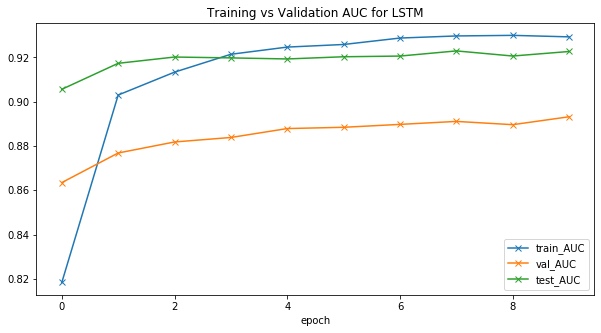

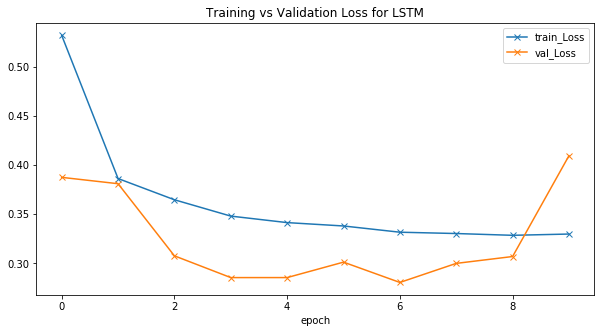

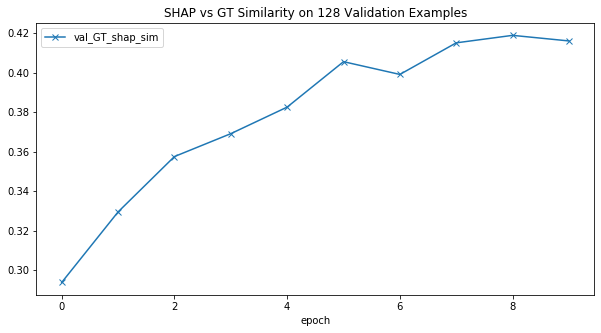

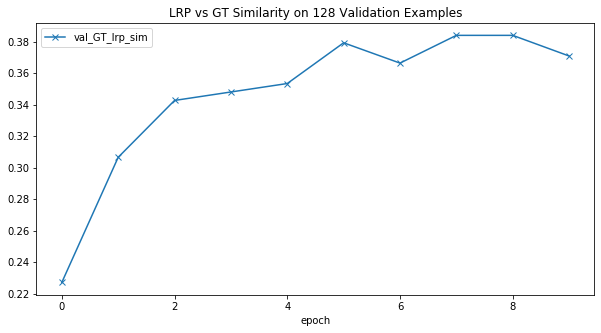

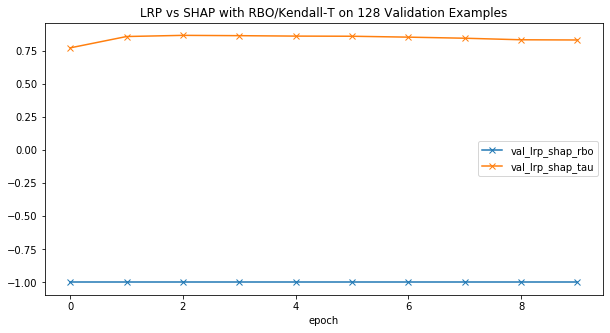

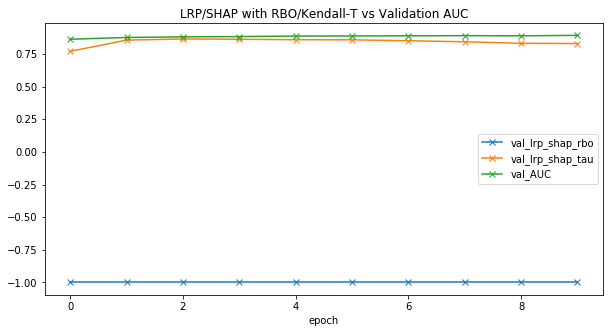

In [30]:
figsize = (10, 5)
df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["train_AUC", "val_AUC", "test_AUC"],
    kind="line",
    marker="x",
)
plt.title("Training vs Validation AUC for LSTM")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["train_Loss", "val_Loss"],
    kind="line",
    marker="x",
)
plt.title("Training vs Validation Loss for LSTM")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_GT_shap_sim"],
    kind="line",
    marker="x",
)
plt.title(
    f"SHAP vs GT Similarity on {MODEL_PARAMS['n_valid_examples']} Validation Examples"
)

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_GT_lrp_sim"],
    kind="line",
    marker="x",
)
plt.title(
    f"LRP vs GT Similarity on {MODEL_PARAMS['n_valid_examples']} Validation Examples"
)

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_lrp_shap_rbo", "val_lrp_shap_tau"],
    kind="line",
    marker="x",
)
plt.title(
    f"LRP vs SHAP with RBO/Kendall-T on {MODEL_PARAMS['n_valid_examples']} Validation Examples"
)

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_lrp_shap_rbo", "val_lrp_shap_tau", "val_AUC"],
    kind="line",
    marker="x",
)
plt.title("LRP/SHAP with RBO/Kendall-T vs Validation AUC")

plt.show()

In [31]:
df_results

,train_AUC,train_Loss,val_AUC,val_Loss,test_AUC,test_Loss,val_lrp_shap_rbo,val_lrp_shap_tau,test_lrp_shap_rbo,test_lrp_shap_tau,val_GT_lrp_sim,val_GT_shap_sim,test_GT_lrp_sim,test_GT_shap_sim
epoch,,,,,,,,,,,,,,
0,0.818389,0.531771,0.863460,0.387498,0.905563,0.387074,-1.0,0.771067,-1.0,0.779704,0.227080,0.293742,0.232252,0.290348
1,0.902978,0.386287,0.876814,0.381041,0.917291,0.381375,-1.0,0.856668,-1.0,0.867167,0.306564,0.329457,0.320271,0.320674
2,0.913305,0.364725,0.881787,0.307753,0.920122,0.308404,-1.0,0.865485,-1.0,0.873563,0.342688,0.357519,0.359702,0.356221
3,0.921368,0.348134,0.883820,0.285654,0.919732,0.286229,-1.0,0.863125,-1.0,0.870260,0.348064,0.369119,0.381022,0.358759
4,0.924613,0.341520,0.887841,0.285669,0.919256,0.286798,-1.0,0.859829,-1.0,0.857311,0.353440,0.382580,0.369148,0.362346
5,0.925789,0.338099,0.888413,0.301360,0.920248,0.302237,-1.0,0.858793,-1.0,0.865469,0.379310,0.405597,0.392616,0.381733
6,0.928694,0.331764,0.889723,0.280724,0.920561,0.281591,-1.0,0.851981,-1.0,0.852402,0.366408,0.399134,0.371889,0.379575
7,0.929636,0.330420,0.891067,0.300094,0.922886,0.301101,-1.0,0.843835,-1.0,0.840464,0.384034,0.415141,0.385653,0.383571
8,0.929906,0.328610,0.889592,0.307063,0.920579,0.308795,-1.0,0.832089,-1.0,0.835522,0.384029,0.418936,0.377014,0.397340


### Save Figures

In [32]:
# for sel_idx in range(len(val_labels)):
#     one_text = [
#         int(token.numpy())
#         for token in val_idxed_text[sel_idx]
#         if int(token.numpy()) != 0
#     ]
#     lrp_model.set_input(one_text)
#     lrp_model.forward_lrp()

#     Rx, Rx_rev, _ = lrp_model.lrp(one_text, 0, eps=1e-6, bias_factor=0)
#     R_words = np.sum(Rx + Rx_rev, axis=1)

#     df = pd.DataFrame()
#     df["lrp_scores"] = R_words
#     df["idx"] = one_text
#     df["seq_idx"] = [x for x in range(len(one_text))]
#     df["token"] = [lstm_model.vocab.itos(x) for x in one_text]
#     df["att_weights"] = lrp_model.get_attn_values()

#     if val_patient_ids[sel_idx] not in valid_results[epoch]:
#         valid_results[epoch][val_patient_ids[sel_idx]] = {}
#     valid_results[epoch][val_patient_ids[sel_idx]] = {}
#     valid_results[epoch][val_patient_ids[sel_idx]]["label"] = val_labels[
#         sel_idx
#     ]
#     valid_results[epoch][val_patient_ids[sel_idx]]["pred"] = lrp_model.s[0]
#     valid_results[epoch][val_patient_ids[sel_idx]]["imp"] = df.copy()

In [33]:
import seaborn as sns

plt.style.use("ggplot")


def ret_label_df(df, colname, dataset):
    len_epoch = df.shape[0]
    plot_df = df[["epoch", colname]].copy()
    plot_df.columns = ["epoch", "AUC"]
    plot_df["dataset"] = dataset

    return plot_df

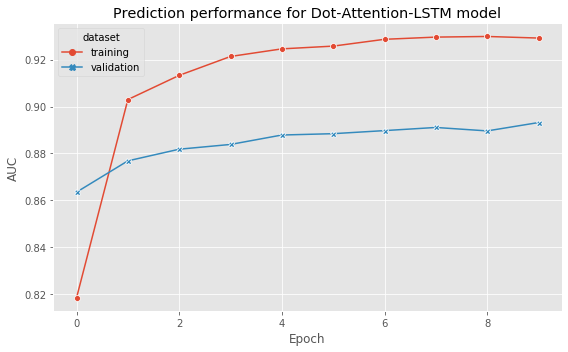

In [34]:
train_df = ret_label_df(df_results.reset_index(), "train_AUC", "training")
val_df = ret_label_df(df_results.reset_index(), "val_AUC", "validation")
plot_df = pd.concat([train_df, val_df])
plt.figure(figsize=(8, 5))
ax = sns.lineplot(
    data=plot_df,
    x="epoch",
    y="AUC",
    hue="dataset",
    markers=True,
    dashes=False,
    style="dataset",
)
ax.set_title("Prediction performance for Dot-Attention-LSTM model")
ax.set_xlabel("Epoch")
plt.tight_layout()
plot_path = os.path.join(PLOT_SAVE_DIR, "LSTM_auc_vs_epoch.png")
plt.savefig(plot_path, dpi=600)

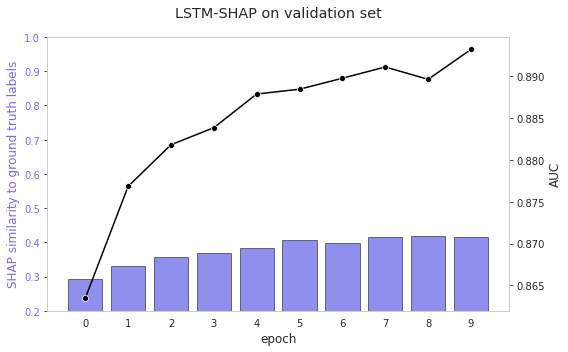

In [35]:
sns.set_style("whitegrid", {"axes.grid": False})
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_results.reset_index(),
    x="epoch",
    y="val_GT_shap_sim",
    color="blue",
    alpha=0.5,
    edgecolor="black",
    linewidth=1,
)
ax.set(ylim=(0.2, 1.0))
ax.set_xlabel("epoch")
ax.set_ylabel("SHAP similarity to ground truth labels", color="mediumslateblue")
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color("mediumslateblue")
ax2 = ax.twinx()
sns.lineplot(
    data=df_results.reset_index(),
    x="epoch",
    y="val_AUC",
    ax=ax2,
    color="black",
    marker="o",
)
ax2.set_ylabel("AUC")
ax.set_title("LSTM-SHAP on validation set")
ax.title.set_position([0.5, 1.05])
plt.tight_layout()
plot_path = os.path.join(PLOT_SAVE_DIR, "LSTM_auc_vs_gt_SHAP_val.png")
plt.savefig(plot_path, dpi=600)

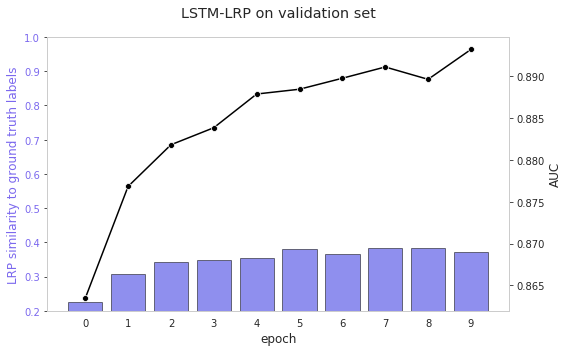

In [36]:
sns.set_style("whitegrid", {"axes.grid": False})
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_results.reset_index(),
    x="epoch",
    y="val_GT_lrp_sim",
    color="blue",
    alpha=0.5,
    edgecolor="black",
    linewidth=1,
)
ax.set(ylim=(0.2, 1.0))
ax.set_xlabel("epoch")
ax.set_ylabel("LRP similarity to ground truth labels", color="mediumslateblue")
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color("mediumslateblue")
ax2 = ax.twinx()
sns.lineplot(
    data=df_results.reset_index(),
    x="epoch",
    y="val_AUC",
    ax=ax2,
    color="black",
    marker="o",
)
ax2.set_ylabel("AUC")
ax.set_title("LSTM-LRP on validation set")
ax.title.set_position([0.5, 1.05])
plt.tight_layout()
plot_path = os.path.join(PLOT_SAVE_DIR, "LSTM_auc_vs_gt_LRP_val.png")
plt.savefig(plot_path, dpi=600)

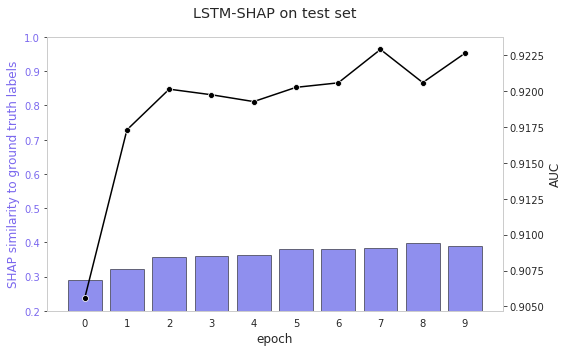

In [37]:
sns.set_style("whitegrid", {"axes.grid": False})
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_results.reset_index(),
    x="epoch",
    y="test_GT_shap_sim",
    color="blue",
    alpha=0.5,
    edgecolor="black",
    linewidth=1,
)
ax.set(ylim=(0.2, 1.0))
ax.set_xlabel("epoch")
ax.set_ylabel("SHAP similarity to ground truth labels", color="mediumslateblue")
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color("mediumslateblue")
ax2 = ax.twinx()
sns.lineplot(
    data=df_results.reset_index(),
    x="epoch",
    y="test_AUC",
    ax=ax2,
    color="black",
    marker="o",
)
ax2.set_ylabel("AUC")
ax.set_title("LSTM-SHAP on test set")
ax.title.set_position([0.5, 1.05])
plt.tight_layout()
plot_path = os.path.join(PLOT_SAVE_DIR, "LSTM_auc_vs_gt_SHAP_test.png")
plt.savefig(plot_path, dpi=600)

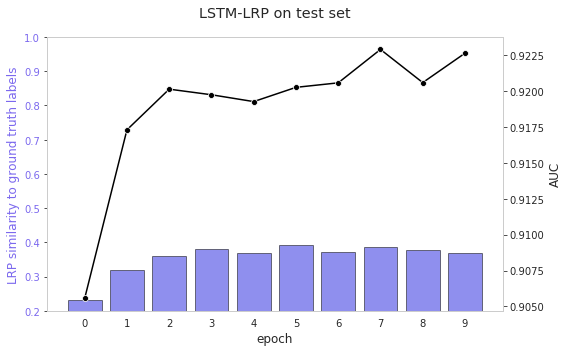

In [38]:
sns.set_style("whitegrid", {"axes.grid": False})
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_results.reset_index(),
    x="epoch",
    y="test_GT_lrp_sim",
    color="blue",
    alpha=0.5,
    edgecolor="black",
    linewidth=1,
)
ax.set(ylim=(0.2, 1.0))
ax.set_xlabel("epoch")
ax.set_ylabel("LRP similarity to ground truth labels", color="mediumslateblue")
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color("mediumslateblue")
ax2 = ax.twinx()
sns.lineplot(
    data=df_results.reset_index(),
    x="epoch",
    y="test_AUC",
    ax=ax2,
    color="black",
    marker="o",
)
ax2.set_ylabel("AUC")
ax.set_title("LSTM-LRP on test set")
ax.title.set_position([0.5, 1.05])
plt.tight_layout()
plot_path = os.path.join(PLOT_SAVE_DIR, "LSTM_auc_vs_gt_LRP_test.png")
plt.savefig(plot_path, dpi=600)

## Visualize SHAP

### Select the best epoch first

In [39]:
def get_best_epoch(df, by="val_AUC"):
    """Get best epoch based on the given dataframe and column"""
    best_epoch = df_results[by].idxmax()
    best_epoch = int(best_epoch)
    return best_epoch

In [40]:
best_epoch = get_best_epoch(df_results, by="val_AUC")
best_epoch

9

In [41]:
selected_epochs = [0, best_epoch]

In [42]:
selected_patients = pd.read_csv(SELECTED_EXAMPLES_PATH, sep=" ", header=None)
selected_patients = selected_patients.values.flatten().tolist()
selected_patients
# selected_patients = ["1OD472J277", "XEK4OM00KJ"]

['SH8FMNYIU', 'RMUKOV6H2']

In [43]:
example_results = {}
for pat_id in selected_patients:
    example_results[pat_id] = {}
    for epoch in range(N_EPOCHS):
        if pat_id in test_results[epoch].keys():
            example_results[pat_id][epoch] = test_results[epoch][pat_id]
example_results.keys()

dict_keys(['SH8FMNYIU', 'RMUKOV6H2'])

In [44]:
# get_all_shap_scores
n_jobs = len(valid_results.keys())
step = int(n_jobs / 2) - 1
for epoch, val_scores in valid_results.items():
    if epoch != best_epoch:
        continue
    all_features = []
    lrp_all_scores = []
    shap_all_scores = []
    attn_all_scores = []
    for pat_id, scores in val_scores.items():
        shap_all_scores.append(
            valid_results[epoch][pat_id]["imp"]["shap_scores"].tolist()
        )
        lrp_all_scores.append(
            valid_results[epoch][pat_id]["imp"]["lrp_scores"].tolist()
        )
        attn_all_scores.append(
            valid_results[epoch][pat_id]["imp"]["att_weights"].tolist()
        )
        all_features.append(valid_results[epoch][pat_id]["imp"]["token"].tolist())

    shap_global_scores = sj_utils.get_global_feature_importance(
        all_features, shap_all_scores, absolute=True
    )
    lrp_global_scores = sj_utils.get_global_feature_importance(
        all_features, lrp_all_scores, absolute=True
    )

    att_global_scores = sj_utils.get_global_feature_importance(
        all_features, attn_all_scores, absolute=True
    )

In [45]:
rows = []
for token in shap_global_scores.keys():
    rows.append(
        [
            token,
            shap_global_scores[token],
            lrp_global_scores[token],
            att_global_scores[token],
        ]
    )

In [46]:
als_df = pd.DataFrame(rows)
als_df.columns = ["features", "shap_scores", "lrp_scores", "attention_weights"]
als_df.head()

,features,shap_scores,lrp_scores,attention_weights
0,h_97530,0.001317,0.006980,0.012790
1,h_92015,0.001428,0.098902,0.011546
2,6_days,0.002305,0.010642,0.012679
3,p_5459_rf,0.003328,0.003818,0.009706
4,h_G8447,0.003841,0.020585,0.009667


In [47]:
MAX_TOKENS = 30

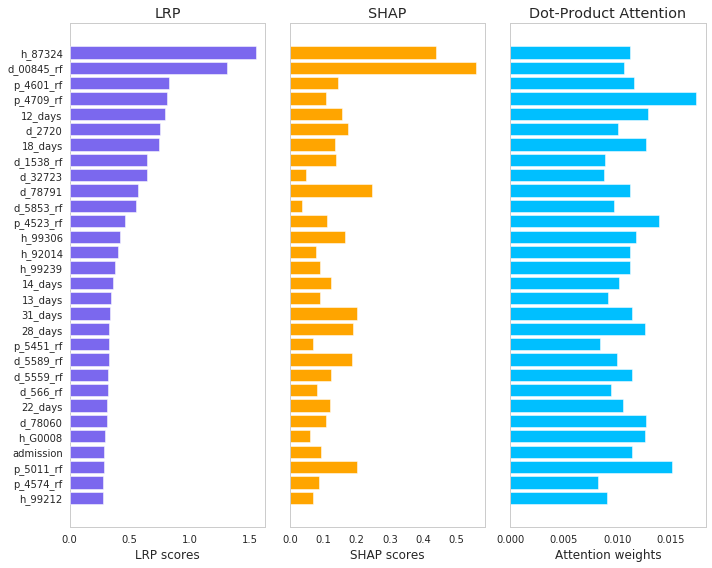

In [48]:
als_df = als_df.sort_values("lrp_scores", ascending=True, inplace=False).reset_index(
    drop=True
)

if MAX_TOKENS is not None:
    als_df = als_df.iloc[-MAX_TOKENS:]

fig = plt.figure(figsize=(10, 8))
axes = fig.subplots(ncols=3, sharey=True)
axes[0].barh(
    als_df.features,
    als_df.lrp_scores,
    color="mediumslateblue",
    align="center",
    zorder=10,
)
axes[0].set(title="LRP", xlabel="LRP scores")
axes[1].barh(als_df.features, als_df.shap_scores, color="orange", align="center")
axes[1].set(title="SHAP", xlabel="SHAP scores")
# axes[0].invert_xaxis()
# axes[1].set_yticks([])

axes[2].barh(
    als_df.features, als_df.attention_weights, color="deepskyblue", align="center"
)
axes[2].set(title="Dot-Product Attention", xlabel="Attention weights")

fig.subplots_adjust(wspace=0.09)
plt.tight_layout()
plot_path = os.path.join(PLOT_SAVE_DIR, f"LSTM_LRP_SHAP_Att_E{best_epoch}.png")
plt.savefig(plot_path, dpi=600)

In [49]:
#### For all dataset

In [50]:
DATA_SPLIT = "test"
BEST_EPOCH = 9
best_epoch = 9
results_path = SHAP_SAVE_DIR_PATTERN.format(DATA_SPLIT, "9_5_times_positives")
results_path

'./output-mix/AE_CDiff/100/original/lstm-att-lrp/20110101/1000/shap/test_shap_9_5_times_positives.pkl'

In [51]:
with open(results_path, "rb") as fp:
    all_results = pickle.load(fp)

In [52]:
# all_results.keys()

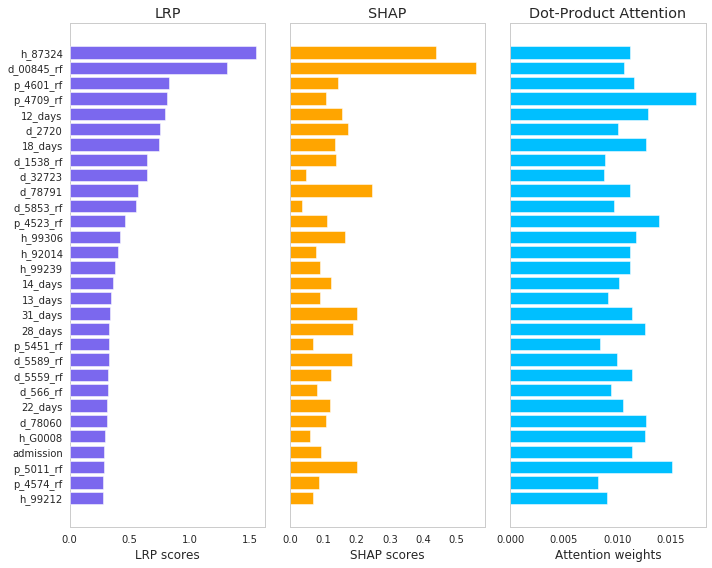

In [53]:
# get_all_shap_scores
n_jobs = len(all_results.keys())
step = int(n_jobs / 2) - 1
for epoch, all_scores in all_results.items():
    if epoch != best_epoch:
        continue
    all_features = []
    lrp_all_scores = []
    shap_all_scores = []
    attn_all_scores = []
    for pat_id, scores in all_scores.items():
        shap_all_scores.append(
            all_results[epoch][pat_id]["imp"]["shap_scores"].tolist()
        )
        lrp_all_scores.append(all_results[epoch][pat_id]["imp"]["lrp_scores"].tolist())
        attn_all_scores.append(
            all_results[epoch][pat_id]["imp"]["att_weights"].tolist()
        )
        all_features.append(all_results[epoch][pat_id]["imp"]["token"].tolist())

    shap_global_scores = sj_utils.get_global_feature_importance(
        all_features, shap_all_scores, absolute=True
    )
    lrp_global_scores = sj_utils.get_global_feature_importance(
        all_features, lrp_all_scores, absolute=True
    )

    att_global_scores = sj_utils.get_global_feature_importance(
        all_features, attn_all_scores, absolute=True
    )

rows = []
for token in shap_global_scores.keys():
    rows.append(
        [
            token,
            shap_global_scores[token],
            lrp_global_scores[token],
            att_global_scores[token],
        ]
    )

als_df = pd.DataFrame(rows)
als_df.columns = ["features", "shap_scores", "lrp_scores", "attention_weights"]

# als_df.sort_values("lrp_scores", ascending=True, inplace=True)
als_df = als_df.sort_values("lrp_scores", ascending=True, inplace=False).reset_index(
    drop=True
)

if MAX_TOKENS is not None:
    als_df = als_df.iloc[-MAX_TOKENS:]

fig = plt.figure(figsize=(10, 8))
axes = fig.subplots(ncols=3, sharey=True)
axes[0].barh(
    als_df.features,
    als_df.lrp_scores,
    color="mediumslateblue",
    align="center",
    zorder=10,
)
axes[0].set(title="LRP", xlabel="LRP scores")
axes[1].barh(als_df.features, als_df.shap_scores, color="orange", align="center")
axes[1].set(title="SHAP", xlabel="SHAP scores")
# axes[0].invert_xaxis()
# axes[1].set_yticks([])

axes[2].barh(
    als_df.features, als_df.attention_weights, color="deepskyblue", align="center"
)
axes[2].set(title="Dot-Product Attention", xlabel="Attention weights")

fig.subplots_adjust(wspace=0.09)
plt.tight_layout()
# plot_path = os.path.join(PLOT_SAVE_DIR, f"LSTM_LRP_SHAP_Att_E{best_epoch}.png")
# plt.savefig(plot_path, dpi=600)
plt.show()

In [54]:
len(all_results.keys())

800

In [55]:
all_results["SH8FMNYIU"].keys()

dict_keys(['label', 'pred', 'imp', 'lrp_shap_t_corr', 'lrp_shap_rbo', 'lrp_sim', 'shap_sim'])

In [56]:
example_results2 = {}
for pat_id in selected_patients:
    example_results2[pat_id] = {}
    for epoch in [BEST_EPOCH]:
        if pat_id in all_results.keys():
            example_results2[pat_id][epoch] = all_results[pat_id]
example_results2.keys()

dict_keys(['SH8FMNYIU', 'RMUKOV6H2'])

In [57]:
# Plot LRP

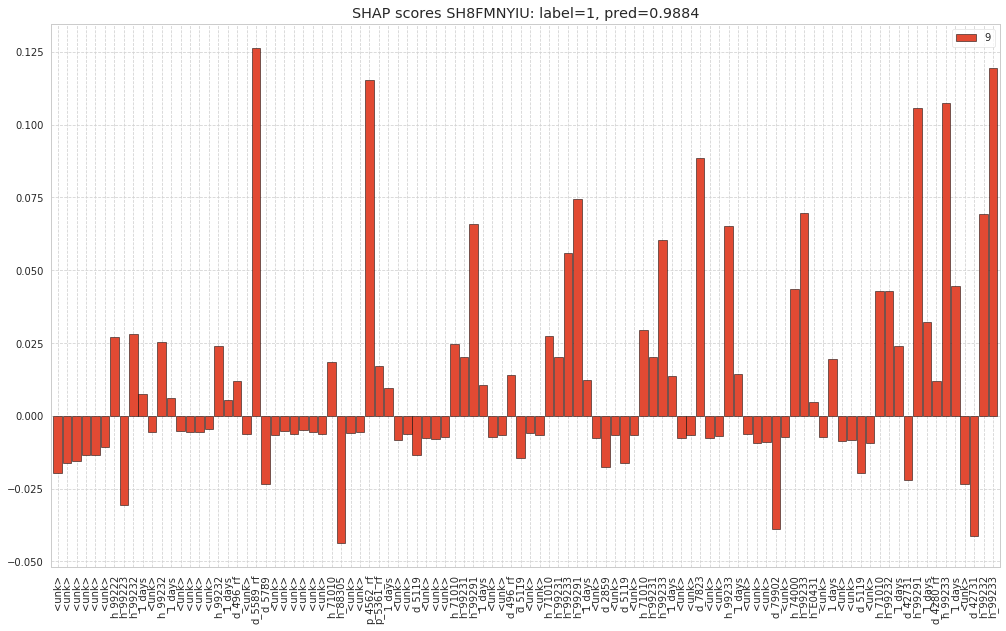

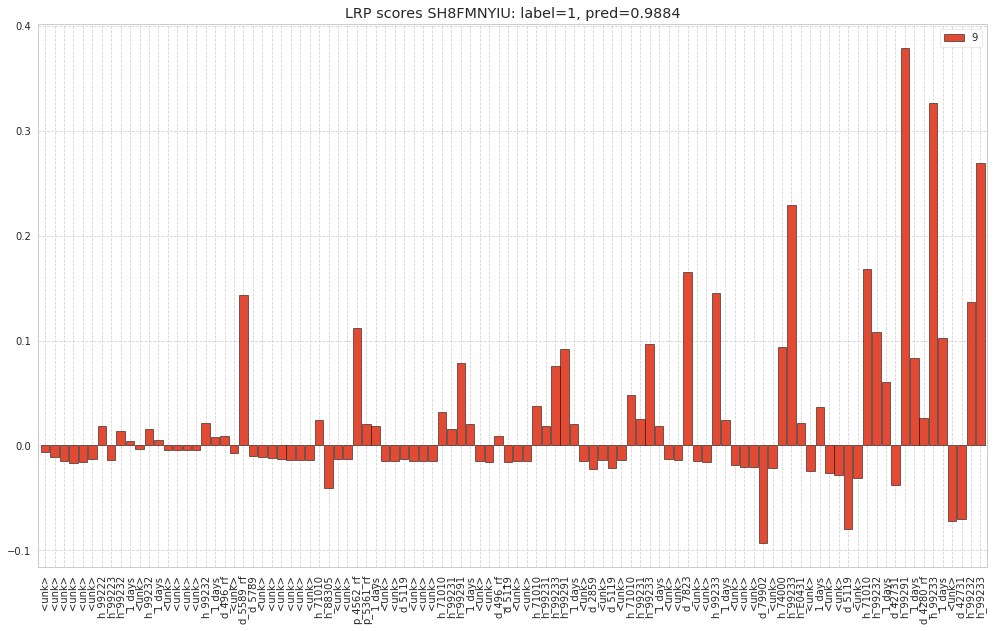

**************************************************


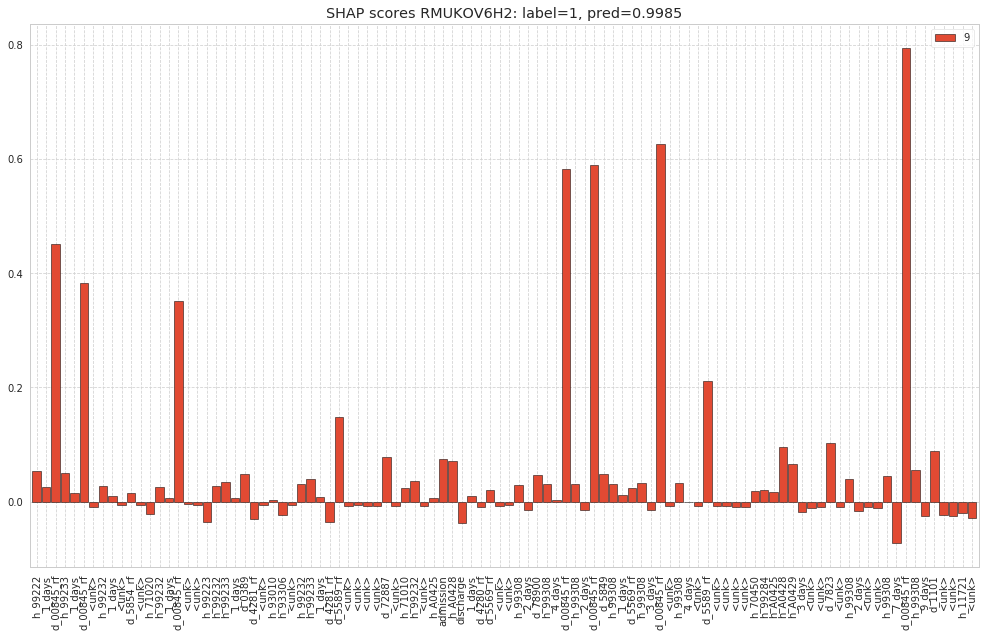

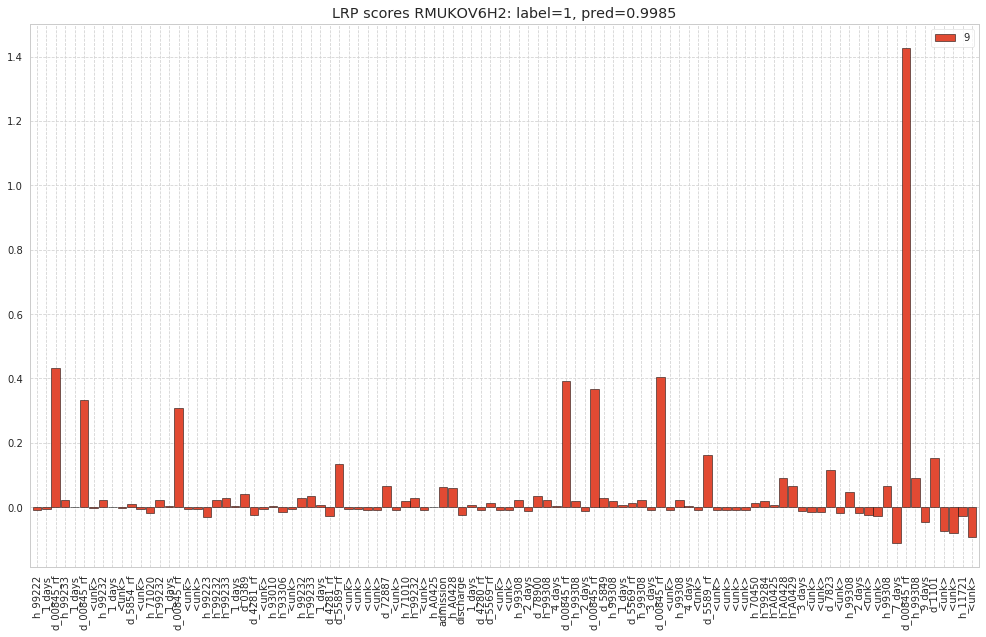

**************************************************


In [58]:
selected_epochs = [BEST_EPOCH]
for uid in example_results2.keys():
    # SHAP
    df = pd.DataFrame()
    for epoch in example_results2[uid].keys():
        df[epoch] = example_results2[uid][epoch]["imp"]["shap_scores"]
    df["token"] = example_results2[uid][epoch]["imp"]["token"]
    df["seq_idx"] = example_results2[uid][epoch]["imp"]["seq_idx"]

    # df[example_results2[uid].keys()].plot.bar(figsize=(17, 7))
    df[selected_epochs].plot.bar(
        align="center", width=0.9, edgecolor="black", figsize=(17, 10)
    )
    plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90, zorder=1)

    lab = example_results2[uid][best_epoch]["label"]
    pred = np.round(
        torch.sigmoid(torch.tensor(example_results2[uid][best_epoch]["pred"])).numpy(),
        4,
    )

    plt.title(f"SHAP scores {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle="--", zorder=3)

    # LRP
    df = pd.DataFrame()
    for epoch in example_results2[uid].keys():
        df[epoch] = example_results2[uid][epoch]["imp"]["lrp_scores"]
    df["token"] = example_results2[uid][epoch]["imp"]["token"]
    df["seq_idx"] = example_results2[uid][epoch]["imp"]["seq_idx"]

    # df[example_results2[uid].keys()].plot.bar(figsize=(17, 7))
    df[selected_epochs].plot.bar(
        align="center", width=0.9, edgecolor="black", figsize=(17, 10)
    )
    plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90, zorder=1)

    lab = example_results2[uid][best_epoch]["label"]
    pred = np.round(
        torch.sigmoid(torch.tensor(example_results2[uid][best_epoch]["pred"])).numpy(),
        4,
    )

    plt.title(f"LRP scores {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle="--", zorder=3)
    plt.show()
    print("*" * 50)

### Distribution of similarities

In [59]:
# valid_results[best_epoch][pid]

In [60]:
rows = []
for pid in valid_results[best_epoch].keys():
    imp_df = valid_results[best_epoch][pid]["imp"]

    # gt similarity
    gt_idx = [x for x, tok in enumerate(imp_df.u_token) if is_value(tok, "cdiff")]
    n_gt = len(gt_idx)
    if n_gt > 0:
        att_idx = np.argsort(np.abs(imp_df.att_weights.values))[::-1][:n_gt]
        att_sim = len(set(att_idx).intersection(gt_idx)) / n_gt
    else:
        att_sim = -1
    pid_data = valid_results[best_epoch][pid]

    rows.append([pid, pid_data["lrp_sim"], pid_data["shap_sim"], att_sim])
sims = pd.DataFrame(rows)
sims.columns = ["patient_id", "lrp_sim", "shap_sim", "att_sim"]
sims.head()

,patient_id,lrp_sim,shap_sim,att_sim
0,TXW0XBNHS,0.200000,0.400000,0.000000
1,HVJ6XSQQV,0.235294,0.294118,0.176471
2,P81YE3JUU,0.565217,0.695652,0.260870
3,Q9K9DMU8A,0.375000,0.437500,0.062500
4,LBNMJ4ZIW,0.133333,0.533333,0.133333


In [61]:
rows = []
for pid in test_results[best_epoch].keys():
    imp_df = test_results[best_epoch][pid]["imp"]

    # gt similarity
    gt_idx = [x for x, tok in enumerate(imp_df.u_token) if is_value(tok, "cdiff")]
    n_gt = len(gt_idx)
    if n_gt > 0:
        att_idx = np.argsort(np.abs(imp_df.att_weights.values))[::-1][:n_gt]
        att_sim = len(set(att_idx).intersection(gt_idx)) / n_gt
    else:
        att_sim = -1
    pid_data = test_results[best_epoch][pid]

    rows.append([pid, pid_data["lrp_sim"], pid_data["shap_sim"], att_sim])
test_sims = pd.DataFrame(rows)
test_sims.columns = ["patient_id", "lrp_sim", "shap_sim", "att_sim"]
test_sims.head()

,patient_id,lrp_sim,shap_sim,att_sim
0,BWCA3E6IA,0.363636,0.409091,0.136364
1,PFU8RB3WB,0.625000,0.562500,0.187500
2,OS3G482UT,0.250000,0.437500,0.187500
3,IPZAEJNQX,0.400000,0.600000,0.133333
4,5N955AFNU,0.375000,0.500000,0.187500


In [62]:
sims.describe()

,lrp_sim,shap_sim,att_sim
count,128.000000,128.000000,128.000000
mean,0.263819,0.305470,0.016898
std,0.509459,0.530282,0.344436
min,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000
50%,0.242647,0.333333,0.000000
75%,0.570972,0.703557,0.141667
max,1.000000,1.000000,1.000000


In [63]:
# !pip install -U seaborn

In [64]:
# fig, axes = plt.subplots(ncols=3, nrows=2, sharex=True, sharey=True, figsize=(10, 5))

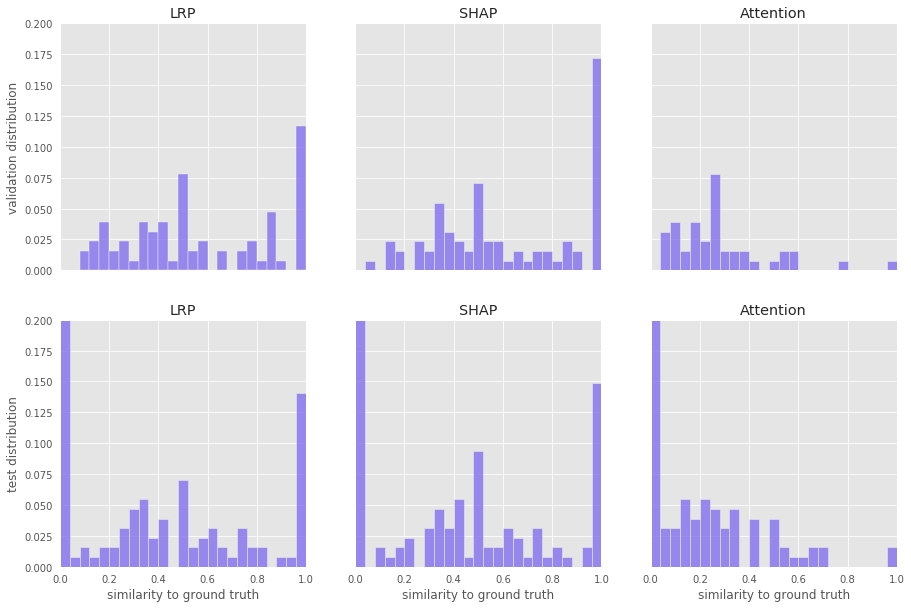

In [65]:
plt.style.use("ggplot")
fig, axes = plt.subplots(ncols=3, nrows=2, sharex=True, sharey=True, figsize=(15, 10))
sns.histplot(
    sims.lrp_sim,
    ax=axes[0][0],
    binwidth=0.04,
    color="mediumslateblue",
    stat="probability",
)
axes[0][0].set_xlabel("similarity to ground truth")
axes[0][0].set_title("LRP")
axes[0][0].set_ylabel("validation distribution")
axes[0][0].set_xlim([0.0, 1.0])
sns.histplot(
    sims.shap_sim,
    ax=axes[0][1],
    binwidth=0.04,
    color="mediumslateblue",
    stat="probability",
)
axes[0][1].set_xlabel("similarity to ground truth")
axes[0][1].set_title("SHAP")
axes[0][1].set_xlim([0.0, 1.0])
sns.histplot(
    sims.att_sim,
    ax=axes[0][2],
    binwidth=0.04,
    color="mediumslateblue",
    stat="probability",
)
axes[0][2].set_xlabel("similarity to ground truth")
axes[0][2].set_title("Attention")
axes[0][2].set_xlim([0.0, 1.0])
plt.ylim([0.0, 0.2])


# For test set
sns.histplot(
    test_sims.lrp_sim,
    ax=axes[1][0],
    binwidth=0.04,
    color="mediumslateblue",
    stat="probability",
)
axes[1][0].set_xlabel("similarity to ground truth")
axes[1][0].set_title("LRP")
axes[1][0].set_ylabel("test distribution")
axes[1][0].set_xlim([0.0, 1.0])
sns.histplot(
    test_sims.shap_sim,
    ax=axes[1][1],
    binwidth=0.04,
    color="mediumslateblue",
    stat="probability",
)
axes[1][1].set_xlabel("similarity to ground truth")
axes[1][1].set_title("SHAP")
axes[1][1].set_xlim([0.0, 1.0])
sns.histplot(
    test_sims.att_sim,
    ax=axes[1][2],
    binwidth=0.04,
    color="mediumslateblue",
    stat="probability",
)
axes[1][2].set_xlabel("similarity to ground truth")
axes[1][2].set_title("Attention")
axes[1][2].set_xlim([0.0, 1.0])
axes[1][0].set_ylim([0.0, 0.2])


# plt.title("Similarity to ground truth histogram")
plot_path = os.path.join(PLOT_SAVE_DIR, "LSTM_sim_dist.png")
plt.savefig(plot_path, dpi=600)

In [66]:
# # get_all_shap_scores
# n_jobs = len(valid_results.keys())
# step = int(n_jobs / 2) - 1
# for epoch, val_scores in valid_results.items():
#     if epoch != best_epoch:
#         continue
#     all_features = []
#     all_scores = []
#     for pat_id, scores in val_scores.items():
#         all_scores.append(valid_results[epoch][pat_id]["imp"]["lrp_scores"].tolist())
#         all_features.append(valid_results[epoch][pat_id]["imp"]["token"].tolist())
#         # print(valid_results[epoch][pat_id]["imp"]["token"])
#     global_scores = sj_utils.get_global_feature_importance(
#         all_features, all_scores, absolute=True
#     )
#     print("LRP for Epoch: " + str(epoch))
#     sj_utils.plot_global_feature_importance(global_scores)

In [67]:
# # get_all_shap_scores
# n_jobs = len(valid_results.keys())
# step = int(n_jobs / 2) - 1
# for epoch, val_scores in valid_results.items():
#     if epoch != best_epoch:
#         continue
#     all_features = []
#     all_scores = []
#     for pat_id, scores in val_scores.items():
#         all_scores.append(valid_results[epoch][pat_id]["imp"]["shap_scores"].tolist())
#         all_features.append(valid_results[epoch][pat_id]["imp"]["token"].tolist())
#         # print(valid_results[epoch][pat_id]["imp"]["token"])
#     global_scores = sj_utils.get_global_feature_importance(
#         all_features, all_scores, absolute=True
#     )
#     print("SHAP for Epoch: " + str(epoch))
#     sj_utils.plot_global_feature_importance(global_scores)

## PLOT SHAP

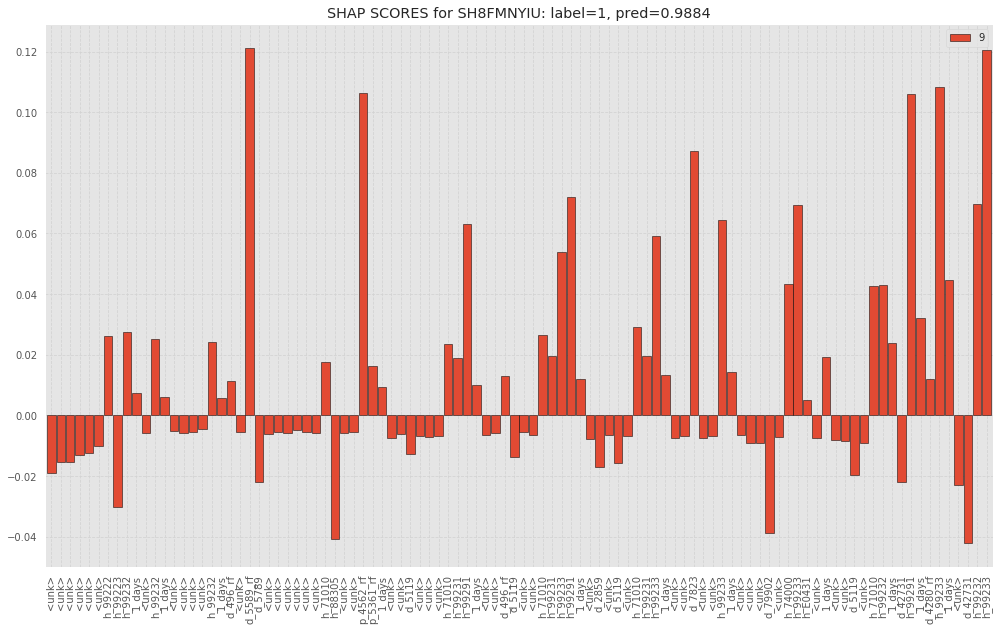

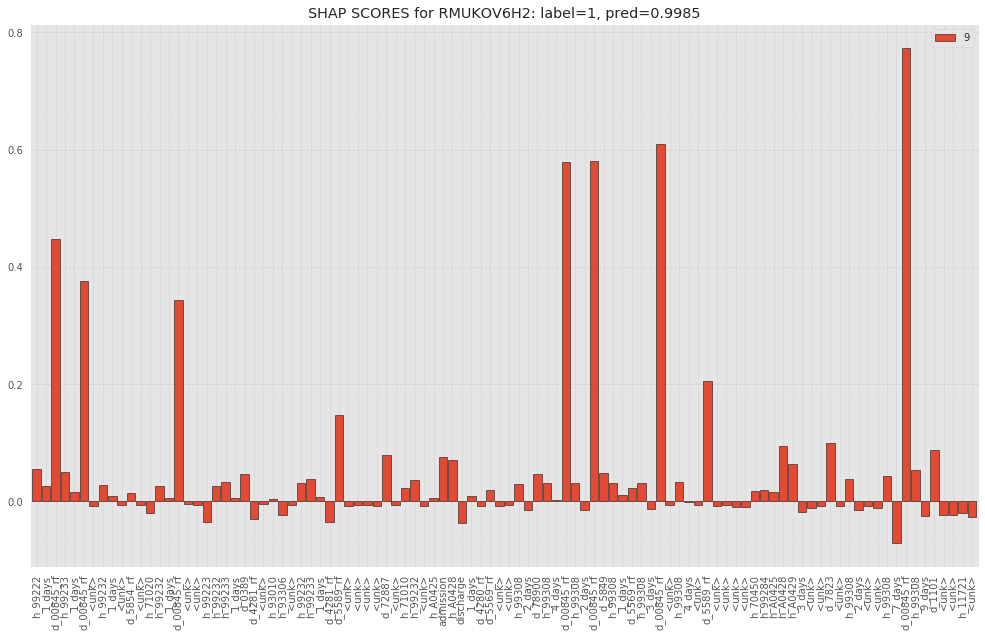

In [68]:
for uid in example_results.keys():
    df = pd.DataFrame()
    for epoch in example_results[uid].keys():
        df[epoch] = example_results[uid][epoch]["imp"]["shap_scores"]
    df["token"] = example_results[uid][epoch]["imp"]["token"]
    df["seq_idx"] = example_results[uid][epoch]["imp"]["seq_idx"]

    # import pdb; pdb.set_trace()
    # df[example_results[uid].keys()].plot.bar(figsize=(17, 7))
    df[selected_epochs].plot.bar(
        align="center", width=0.9, edgecolor="black", figsize=(17, 10)
    )
    plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90)

    lab = example_results[uid][best_epoch]["label"]
    pred = np.round(
        torch.sigmoid(torch.tensor(example_results[uid][best_epoch]["pred"])).numpy(), 4
    )

    plt.title(f"SHAP SCORES for {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle="--")

    plt.show()

## PLOT LRP

In [69]:
plt.rcParams["axes.axisbelow"] = True

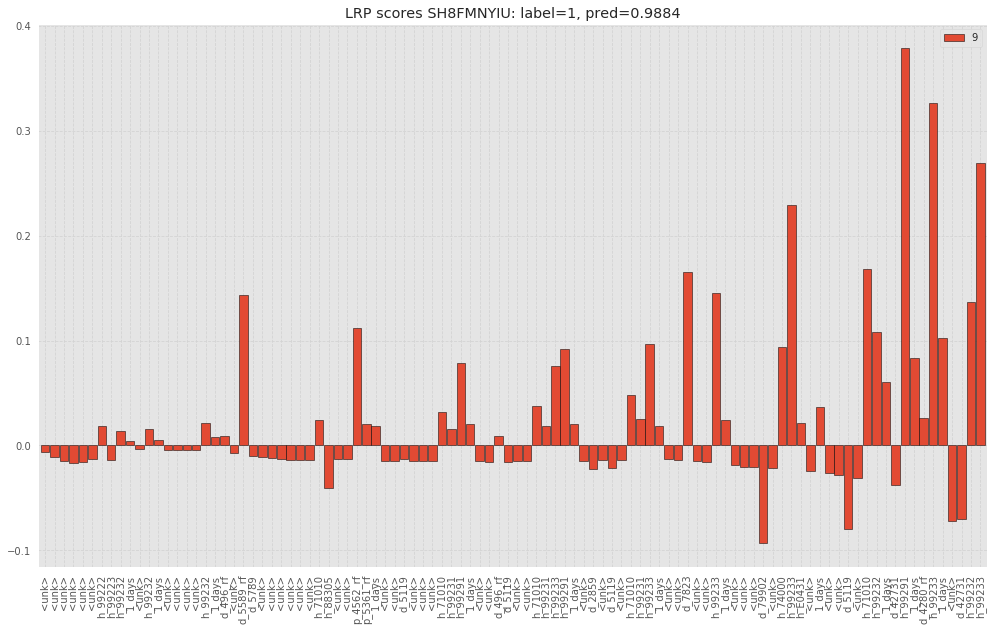

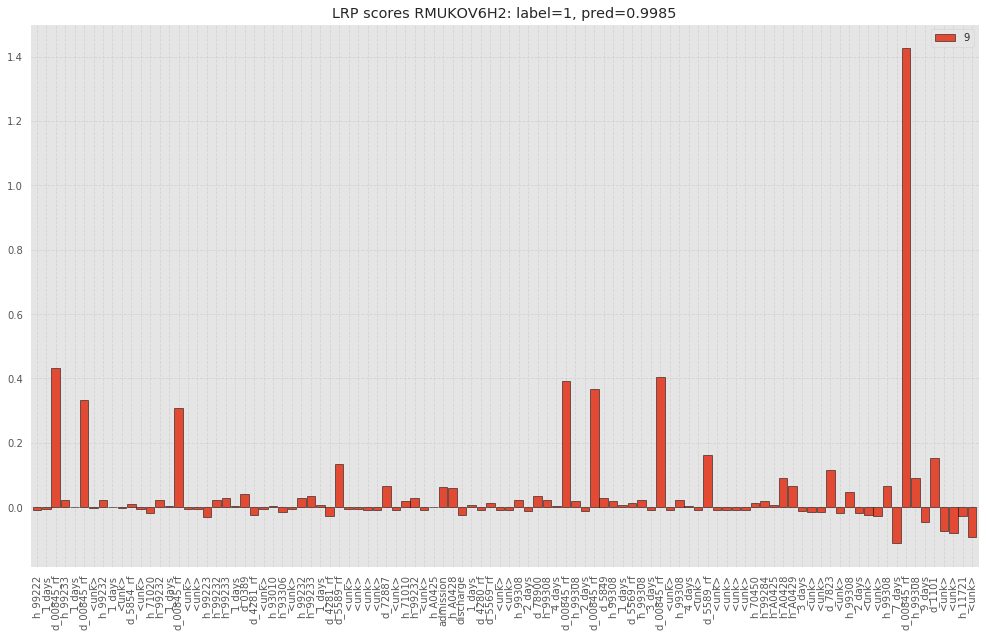

In [70]:
for uid in example_results.keys():
    df = pd.DataFrame()
    for epoch in example_results[uid].keys():
        df[epoch] = example_results[uid][epoch]["imp"]["lrp_scores"]
    df["token"] = example_results[uid][epoch]["imp"]["token"]
    df["seq_idx"] = example_results[uid][epoch]["imp"]["seq_idx"]

    # df[example_results[uid].keys()].plot.bar(figsize=(17, 7))
    df[selected_epochs].plot.bar(
        align="center", width=0.9, edgecolor="black", figsize=(17, 10)
    )
    plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90, zorder=1)

    lab = example_results[uid][best_epoch]["label"]
    pred = np.round(
        torch.sigmoid(torch.tensor(example_results[uid][best_epoch]["pred"])).numpy(), 4
    )

    plt.title(f"LRP scores {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle="--", zorder=3)

## PLOT LSTM LRP & SHAP, LRP & SHAP & Attention scores separately

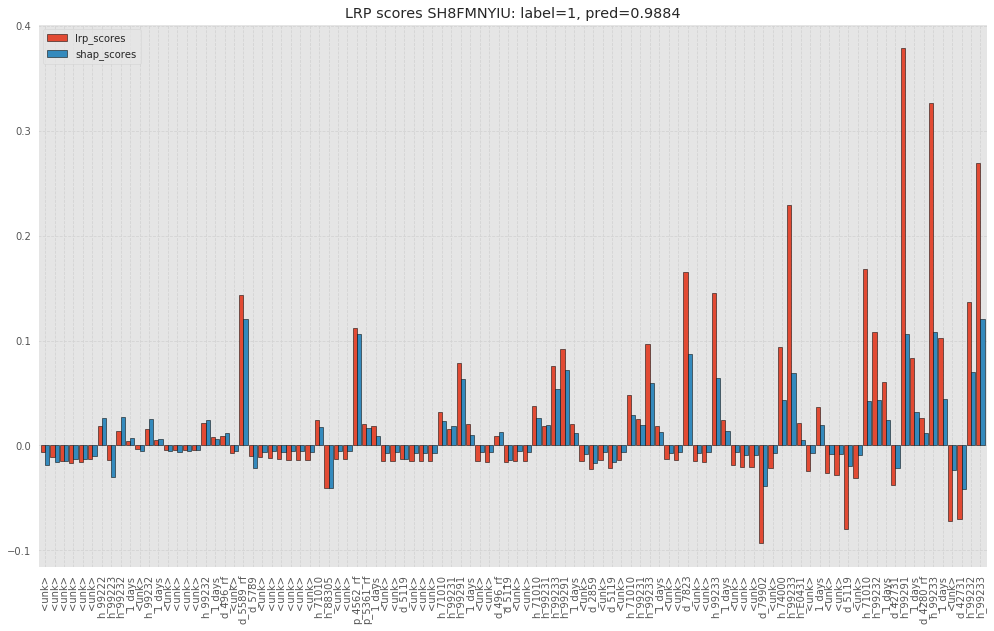

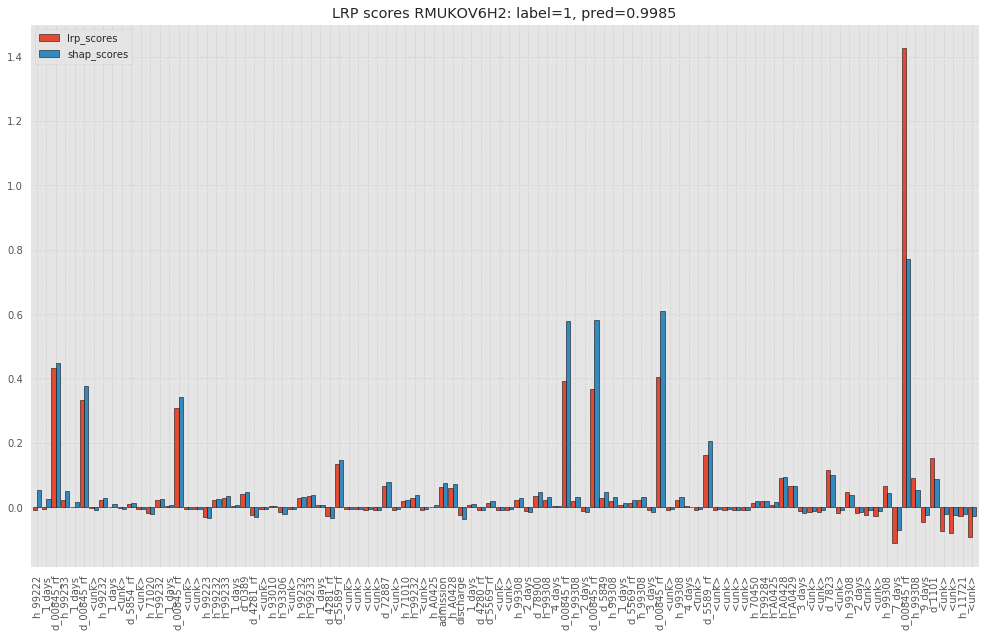

In [71]:
for uid in example_results.keys():
    df = pd.DataFrame()
    df["lrp_scores"] = example_results[uid][best_epoch]["imp"]["lrp_scores"]
    df["token"] = example_results[uid][best_epoch]["imp"]["token"]
    df["seq_idx"] = example_results[uid][best_epoch]["imp"]["seq_idx"]
    df["shap_scores"] = example_results[uid][best_epoch]["imp"]["shap_scores"]
    df["att_scores"] = example_results[uid][best_epoch]["imp"]["att_weights"]

    df[["lrp_scores", "shap_scores"]].plot.bar(
        align="center", width=0.9, edgecolor="black", figsize=(17, 10)
    )
    plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90, zorder=1)

    lab = example_results[uid][best_epoch]["label"]
    pred = np.round(
        torch.sigmoid(torch.tensor(example_results[uid][best_epoch]["pred"])).numpy(), 4
    )

    plt.title(f"LRP scores {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle="--", zorder=3)

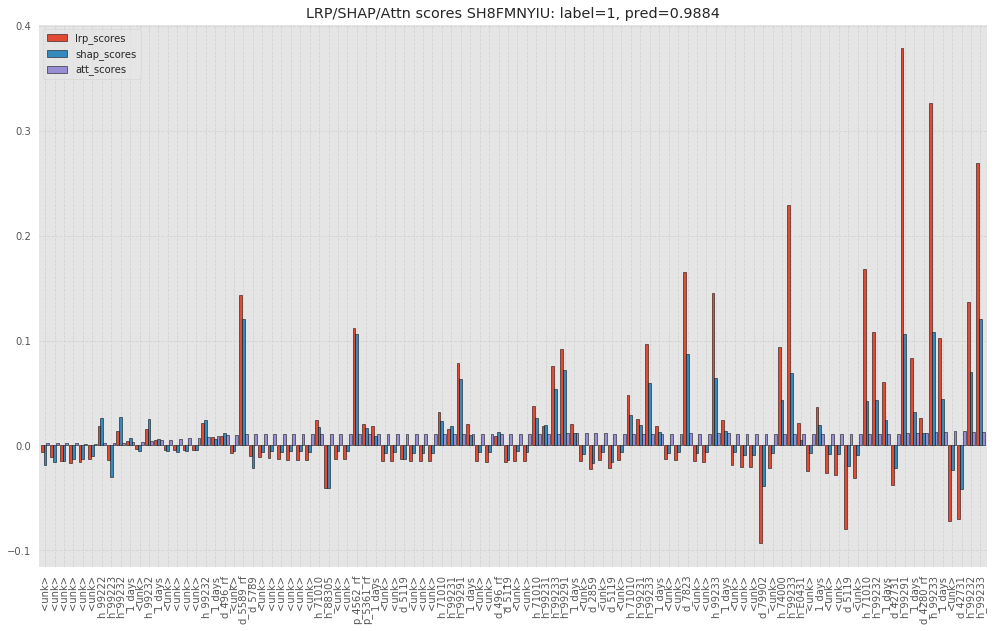

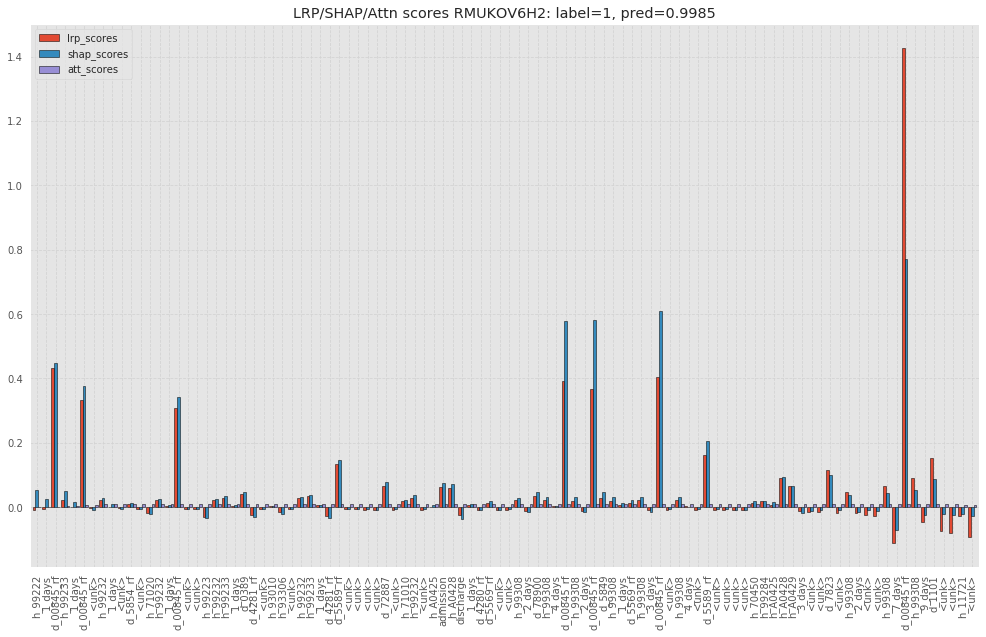

In [72]:
for uid in example_results.keys():
    df = pd.DataFrame()
    df["lrp_scores"] = example_results[uid][best_epoch]["imp"]["lrp_scores"]
    df["token"] = example_results[uid][best_epoch]["imp"]["token"]
    df["seq_idx"] = example_results[uid][best_epoch]["imp"]["seq_idx"]
    df["shap_scores"] = example_results[uid][best_epoch]["imp"]["shap_scores"]
    df["att_scores"] = example_results[uid][best_epoch]["imp"]["att_weights"]

    df[["lrp_scores", "shap_scores", "att_scores"]].plot.bar(
        align="center", width=0.9, edgecolor="black", figsize=(17, 10)
    )
    plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90, zorder=1)

    lab = example_results[uid][epoch]["label"]
    pred = np.round(
        torch.sigmoid(torch.tensor(example_results[uid][best_epoch]["pred"])).numpy(), 4
    )

    plt.title(f"LRP/SHAP/Attn scores {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle="--", zorder=3)

# Plot example results vertically, along with XGBoost in second portion

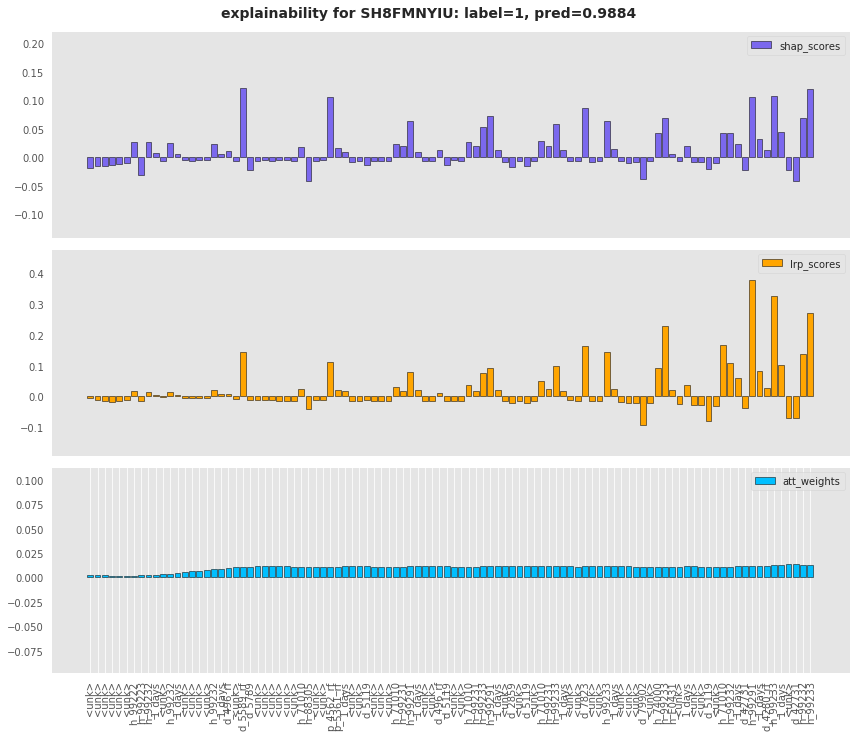

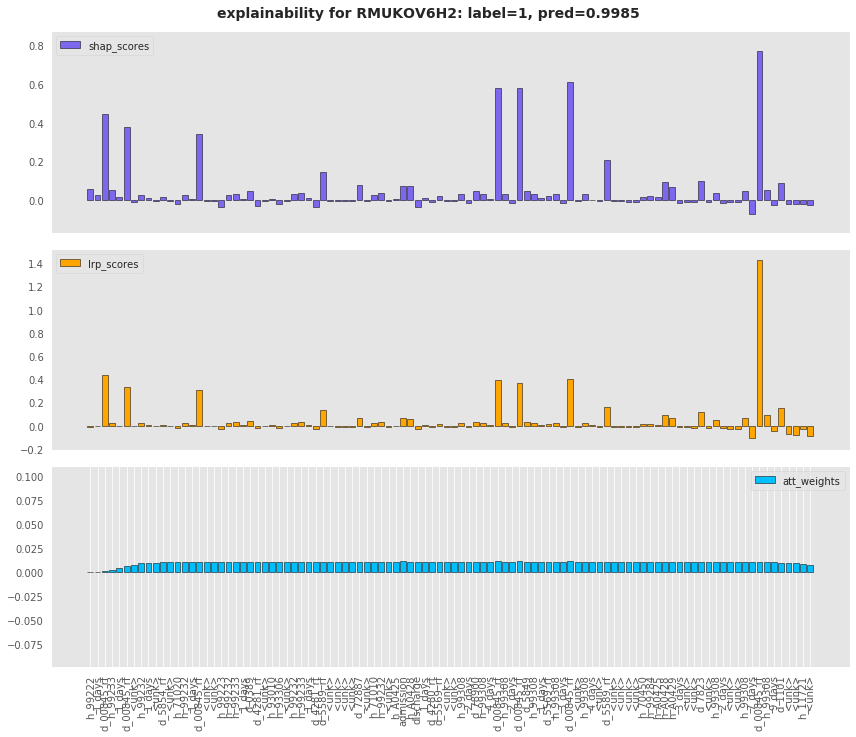

In [73]:
for uid in example_results.keys():
    df = pd.DataFrame()
    df["lrp_scores"] = example_results[uid][best_epoch]["imp"]["lrp_scores"]
    df["token"] = example_results[uid][best_epoch]["imp"]["token"]
    df["seq_idx"] = example_results[uid][best_epoch]["imp"]["seq_idx"]
    df["shap_scores"] = example_results[uid][best_epoch]["imp"]["shap_scores"]
    df["att_weights"] = example_results[uid][best_epoch]["imp"]["att_weights"]
    df["u_token"] = [str(seq) + "_" + tok for tok, seq in zip(df.token, df.seq_idx)]

    label = example_results[uid][best_epoch]["label"][0]
    pred_prob = example_results[uid][best_epoch]["pred"]

    figsize = (12, 10)
    fig = plt.figure(figsize=figsize)
    axes = fig.subplots(nrows=3, ncols=1)

    methods = ["shap_scores", "lrp_scores", "att_weights"]
    for row, color, method in zip(
        axes, ["mediumslateblue", "orange", "deepskyblue"], methods
    ):
        row.bar(
            df["u_token"], df[method], 0.8, label=method, color=color, edgecolor="black"
        )
        if method != methods[-1]:
            row.set_xticks([])
        else:
            row.set_xticklabels(df["token"].tolist(), rotation=90)
        row.grid(axis="y")
        row.set_ylim((df[method].min() - 0.1, df[method].max() + 0.1))
        row.legend()

    plt.tight_layout()
    prob = float(torch.sigmoid(torch.Tensor([pred_prob])))
    st = fig.suptitle(
        f"explainability for {uid}: label={label}, pred={prob:.4}",
        fontsize=14,
        fontweight="bold",
    )
    st.set_y(1.02)
    fig.subplots_adjust(top=0.9)
    plt.tight_layout()
    plot_path = os.path.join(
        PLOT_SAVE_DIR, "LSTM_perpatient_" + uid + f"_label{label}.png"
    )
    plt.savefig(plot_path, dpi=600, bbox_inches="tight")
    plt.show()

## Combine XGB

In [74]:
with open(XGB_BEST_SHAP_PATH, "rb") as f:
    xgb_test_results = pickle.load(f)

In [75]:
xgb_test_results[uid].keys()

dict_keys(['features_xgb', 'd_00845', 'xgb_pred', 'xgb_shap'])

In [76]:
def concat_images(imga, imgb):
    """
    Combines two color image ndarrays side-by-side.
    """
    ha, wa = imga.shape[:2]
    hb, wb = imgb.shape[:2]
    max_width = np.max([wa, wb])
    total_height = ha + hb
    new_img = np.zeros(shape=(total_height, max_width, 3))
    new_img[:ha, :wa] = imga
    new_img[ha : ha + hb, :wa] = imgb
    return new_img


def concat_n_images(image_path_list):
    """
    Combines N color images from a list of image paths.
    """
    output = None
    for i, img_path in enumerate(image_path_list):
        img = plt.imread(img_path)[:, :, :3]
        if i == 0:
            output = img
        else:
            output = concat_images(output, img)
    return output

In [ ]:
for uid in example_results.keys():
    df = pd.DataFrame()
    df["lrp_scores"] = example_results[uid][best_epoch]["imp"]["lrp_scores"]
    df["token"] = example_results[uid][best_epoch]["imp"]["token"]
    df["seq_idx"] = example_results[uid][best_epoch]["imp"]["seq_idx"]
    df["lstm_shap_scores"] = example_results[uid][best_epoch]["imp"]["shap_scores"]
    df["att_weights"] = example_results[uid][best_epoch]["imp"]["att_weights"]
    df["u_token"] = [str(seq) + "_" + tok for tok, seq in zip(df.token, df.seq_idx)]
    df = df[df["token"] != "<unk>"]
    days = ~(df["token"].str.contains("day"))
    df = df[days.tolist()]

    xgb_imp = []
    for token in df.token.tolist():
        idx = xgb_test_results[uid]["features_xgb"].index(token)
        xgb_imp.append(xgb_test_results[uid]["xgb_shap"][idx])
    df["xgb_shap_scores"] = xgb_imp

    shap_df = pd.DataFrame()
    shap_df["token"] = xgb_test_results[uid]["features_xgb"]
    shap_df["token"] = [
        "1_" + tok if tok in df.token.values else "0_" + tok for tok in shap_df.token
    ]
    shap_df["xgb_shap_scores"] = xgb_test_results[uid]["xgb_shap"]

    label = example_results[uid][best_epoch]["label"][0]
    pred_prob = example_results[uid][best_epoch]["pred"]

    figsize = (12, 10)
    fig = plt.figure(figsize=figsize)
    axes = fig.subplots(nrows=4, ncols=1)

    methods = ["lstm_shap_scores", "lrp_scores", "att_weights", "xgb_shap_scores"]
    for row, color, method in zip(
        axes, ["mediumslateblue", "orange", "deepskyblue", "limegreen"], methods
    ):
        row.bar(
            df["u_token"], df[method], 0.8, label=method, color=color, edgecolor="black"
        )
        if method != methods[-1]:
            row.set_xticks([])
        else:
            row.set_xticklabels(df["token"].tolist(), rotation=90)
        row.grid(axis="y")
        row.set_ylim((df[method].min() - 0.1, df[method].max() + 0.1))
        row.legend()

    plt.tight_layout()
    prob = float(torch.sigmoid(torch.Tensor([pred_prob])))
    st = fig.suptitle(
        f"explainability for {uid}: label={label}, lstm_pred={prob:.4}",
        fontsize=14,
        fontweight="bold",
    )
    # st.set_y(0.93)
    st.set_y(1.02)
    fig.subplots_adjust(top=0.9)
    plt.tight_layout()
    plot_path = os.path.join(PLOT_SAVE_DIR, "XGB_LSTM_perpatient_" + uid + ".png")
    plt.savefig(plot_path, dpi=600, bbox_inches="tight")

    if MAX_TOKENS is not None:
        idx = np.argsort(np.abs(shap_df.xgb_shap_scores.values))[::-1]
        shap_df = shap_df.iloc[idx]
        #         shap_df = shap_df.sort_values(
        #             "xgb_shap_scores", ascending=False, inplace=False
        #         ).reset_index(drop=True)

        shap_df = shap_df.iloc[:MAX_TOKENS]

    # import pdb; pdb.set_trace()
    figsize = (12, 8)
    fig2 = plt.figure(figsize=figsize)
    axes2 = fig2.subplots(nrows=1, ncols=1)
    axes2.bar(
        shap_df.token, shap_df.xgb_shap_scores, color="limegreen", edgecolor="black"
    )
    axes2.set_xticklabels(shap_df.token, rotation=90)

    plt.title(
        f"explainability for XGBoost only, xgb_pred={xgb_test_results[uid]['xgb_pred']:.4}",
        fontweight="bold",
    )
    plt.tight_layout()
    fig.subplots_adjust(top=0.9)
    plot_path = os.path.join(PLOT_SAVE_DIR, "XGB_perpatient_" + uid + ".png")
    plt.savefig(plot_path, dpi=600, bbox_inches="tight")